### Install Libraries Needed

In [5]:
!pip install ipywidgets

### Import

In [ ]:

import os
import shutil
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import librosa
import librosa.display
import tensorflow as tf
from tqdm import tqdm
from sklearn.model_selection import GroupShuffleSplit
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils import class_weight
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dense, Dropout, GlobalAveragePooling2D, LSTM, Bidirectional, Reshape, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.applications import EfficientNetB0, ResNet50, Xception
from tensorflow.keras.applications.efficientnet import preprocess_input as eff_preprocess
from tensorflow.keras.applications.resnet50 import preprocess_input as res_preprocess
from tensorflow.keras.applications.xception import preprocess_input as xcp_preprocess
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# CONFIG
BASE_DIR = r"Dataset" 
FACE_PATH = "data_1/faces_1/"
AUDIO_PATH = "data_1/audio_specs_1/"
MODEL_DIR = "models_zoo_1/"

os.makedirs(FACE_PATH, exist_ok=True)
os.makedirs(AUDIO_PATH, exist_ok=True)
os.makedirs(MODEL_DIR, exist_ok=True)

IMG_SIZE = (224, 224)
BATCH_SIZE = 16

print(f"TensorFlow Version: {tf.__version__}")
print(f"GPU Available: {len(tf.config.list_physical_devices('GPU')) > 0}")

TensorFlow Version: 2.20.0
GPU Available: False


### Merge Dataset, EDA

In [25]:
def parse_datasets_auto(base_path):
    data = []
    print(f"Scanning {base_path} recursively...")
    
    rav_map = {
        "01": "neutral", "02": "neutral", "03": "happy", "04": "sad", 
        "05": "angry", "06": "fear", "07": "disgust", "08": "surprise"
    }
    crema_map = {
        "ANG": "angry", "DIS": "disgust", "FEA": "fear", 
        "HAP": "happy", "NEU": "neutral", "SAD": "sad"
    }

    for root, dirs, files in os.walk(base_path):
        for file in files:
            # RAVDESS
            if file.endswith('.mp4') and '-' in file:
                parts = file.split('.')[0].split('-')
                if len(parts) == 7:
                    emo_code = parts[2]
                    actor_id = parts[6]
                    if emo_code in rav_map:
                        data.append({
                            "path": os.path.join(root, file),
                            "source": "RAVDESS",
                            "label": rav_map[emo_code],
                            "actor": f"RAV_{actor_id}",
                            "original_id": f"RAV_{file}"
                        })
                        continue

            # CREMA-D
            if (file.endswith('.flv') or file.endswith('.mp4')) and '_' in file:
                parts = file.split('_')
                if len(parts) >= 3:
                    actor_id = parts[0]
                    emo_code = parts[2]
                    if emo_code in crema_map:
                        data.append({
                            "path": os.path.join(root, file),
                            "source": "CREMA-D",
                            "label": crema_map[emo_code],
                            "actor": f"CRE_{actor_id}",
                            "original_id": f"CRE_{file}"
                        })

    return pd.DataFrame(data)

full_df = parse_datasets_auto(BASE_DIR)

if len(full_df) == 0:
    print("WARNING: No files found! Check your BASE_DIR path.")
else:
    EMOTIONS = sorted(full_df['label'].unique())
    NUM_CLASSES = len(EMOTIONS)
    print(f"\nSuccess! Found {len(full_df)} files.")
    print(f"Emotions Found: {EMOTIONS}")

Scanning Dataset recursively...

Success! Found 9960 files.
Emotions Found: ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']


C:\Users\User\AppData\Local\Temp\ipykernel_18332\2443238697.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=full_df, x='label', order=EMOTIONS, palette='viridis')
C:\Users\User\AppData\Local\Temp\ipykernel_18332\2443238697.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=full_df, x='source', palette='magma')


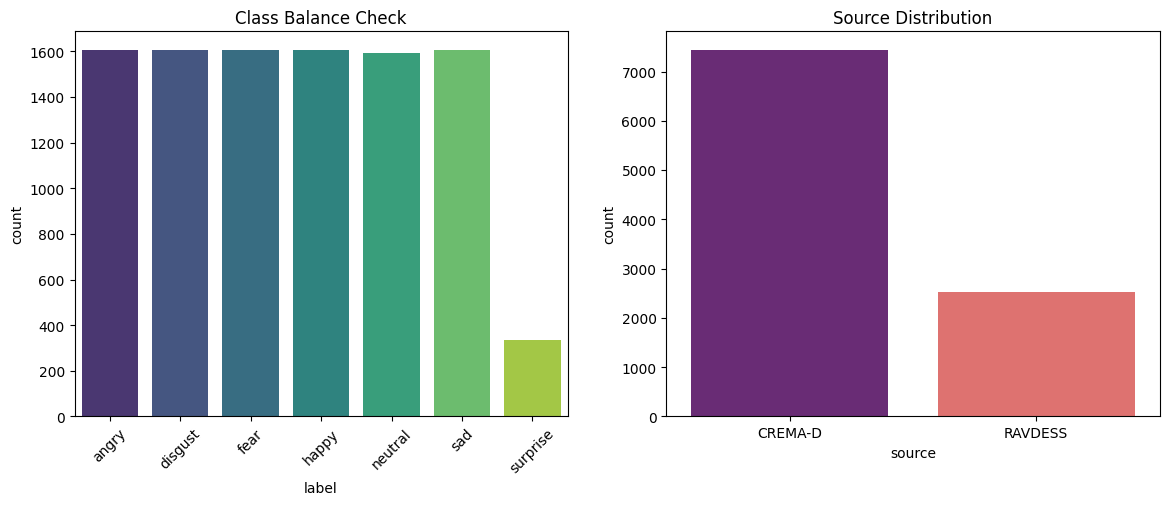


Computed Class Weights: {0: np.float64(0.8859633517167764), 1: np.float64(0.8859633517167764), 2: np.float64(0.8854120366254778), 3: np.float64(0.8854120366254778), 4: np.float64(0.8943162431534525), 5: np.float64(0.8854120366254778), 6: np.float64(4.23469387755102)}


In [29]:
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
sns.countplot(data=full_df, x='label', order=EMOTIONS, palette='viridis')
plt.title("Class Balance Check"); plt.xticks(rotation=45)
plt.subplot(1, 2, 2)
sns.countplot(data=full_df, x='source', palette='magma')
plt.title("Source Distribution"); plt.show()

y_ints = [EMOTIONS.index(x) for x in full_df['label']]
class_weights_arr = class_weight.compute_class_weight(
    class_weight='balanced', classes=np.unique(y_ints), y=y_ints
)
class_weights_dict = dict(enumerate(class_weights_arr))
print("\nComputed Class Weights:", class_weights_dict)

### Audio Extraction

In [ ]:
import librosa
from moviepy.editor import VideoFileClip
from tqdm.notebook import tqdm

def extract_audio_spectrogram(video_path, save_path):
    temp_wav = f"temp_{os.path.basename(save_path)}.wav"
    try:
        try:
            video = VideoFileClip(video_path)
            audio = video.audio
            if audio is None: return False
            audio.write_audiofile(temp_wav, fps=16000, logger=None)
            video.close()
        except Exception:
            return False

        y, sr = librosa.load(temp_wav, sr=16000)
        y_trimmed, _ = librosa.effects.trim(y, top_db=20)
        max_len = 16000 * 3
        
        if len(y_trimmed) > max_len:
            y_final = y_trimmed[:max_len]
        else:
            padding = max_len - len(y_trimmed)
            y_final = np.pad(y_trimmed, (0, padding), 'constant')
            
        mel = librosa.feature.melspectrogram(y=y_final, sr=sr, n_mels=128)
        mel_db = librosa.power_to_db(mel, ref=np.max)
        mel_norm = (mel_db - mel_db.min()) / (mel_db.max() - mel_db.min() + 1e-6)
        
        spec_img = np.stack([mel_norm]*3, axis=-1)
        spec_resized = cv2.resize(spec_img, (224, 224))
        np.save(save_path, spec_resized)
        return True
    except Exception as e:
        print(f"Error processing {video_path}: {e}")
        return False
    finally:
        if os.path.exists(temp_wav): os.remove(temp_wav)

audio_metadata = []
if not os.path.exists(AUDIO_PATH): os.makedirs(AUDIO_PATH)

print("Extracting Audio Features...")
for idx, row in tqdm(full_df.iterrows(), total=len(full_df)):
    fname = row['original_id'] + ".npy"
    save_p = os.path.join(AUDIO_PATH, fname)
    
    if os.path.exists(save_p):
        d = row.to_dict()
        d['audio_path'] = save_p
        audio_metadata.append(d)
        continue
        
    if extract_audio_spectrogram(row['path'], save_p):
        d = row.to_dict()
        d['audio_path'] = save_p
        audio_metadata.append(d)

audio_df = pd.DataFrame(audio_metadata)
print(f"Audio Extraction Complete. Valid samples: {len(audio_df)}")

Extracting Audio Features...


  0%|          | 0/9960 [00:00<?, ?it/s]

Audio Extraction Complete. Valid samples: 9960


### Face Extraction

In [ ]:
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

def process_faces(df):
    face_data = []
    print("Extracting Faces...")
    
    for idx, row in tqdm(df.iterrows(), total=len(df)):
        cap = cv2.VideoCapture(row['path'])
        total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        if total_frames <= 0:
            cap.release(); continue
            
        target_frame = int(total_frames / 2)
        cap.set(cv2.CAP_PROP_POS_FRAMES, target_frame)
        ret, frame = cap.read()
        
        if ret:
            gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            faces = face_cascade.detectMultiScale(gray, 1.1, 5)
            
            if len(faces) > 0:
                x, y, w, h = sorted(faces, key=lambda f: f[2]*f[3], reverse=True)[0]
                margin = int(w * 0.2)
                x1 = max(0, x - margin); y1 = max(0, y - margin)
                x2 = min(frame.shape[1], x + w + margin); y2 = min(frame.shape[0], y + h + margin)
                face_img = frame[y1:y2, x1:x2]
                
                try:
                    face_img = cv2.resize(face_img, (224, 224))
                    fname = f"{row['original_id']}_face.jpg"
                    save_p = os.path.join(FACE_PATH, fname)
                    cv2.imwrite(save_p, face_img)
                    
                    d = row.to_dict()
                    d['face_path'] = save_p
                    face_data.append(d)
                except Exception: pass
        cap.release()
    return pd.DataFrame(face_data)

if not os.path.exists(FACE_PATH): os.makedirs(FACE_PATH)
face_df = process_faces(audio_df)
print(f"Face Extraction Complete. Valid samples: {len(face_df)}")

Extracting Faces...


  0%|          | 0/9960 [00:00<?, ?it/s]

Face Extraction Complete. Valid samples: 9949


### Save Dataset

In [ ]:
output_dir = r"C:\Users\User\Multimodel AI\data_1"
os.makedirs(output_dir, exist_ok=True)

if 'audio_df' in locals() and not audio_df.empty:
    audio_df.to_csv(os.path.join(output_dir, "audio_metadata.csv"), index=False)
if 'face_df' in locals() and not face_df.empty:
    face_df.to_csv(os.path.join(output_dir, "face_metadata.csv"), index=False)

### Generator & Encoding & Data Splitting

In [4]:
from tensorflow.keras.utils import Sequence, to_categorical
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le.fit(sorted(EMOTIONS)) 

class NpyDataGenerator(Sequence):
    def __init__(self, df, preprocess_func, batch_size=16, target_size=(224,224), shuffle=True, is_image=False):
        self.df = df
        self.batch_size = batch_size
        self.preprocess_func = preprocess_func
        self.target_size = target_size
        self.shuffle = shuffle
        self.is_image = is_image
        self.indices = np.arange(len(df))
        self.labels = le.transform(self.df[label_col])
        self.num_classes = len(le.classes_)
        self.on_epoch_end()

    def __len__(self): return int(np.ceil(len(self.df) / self.batch_size))

    def __getitem__(self, index):
        idx_batch = self.indices[index * self.batch_size:(index + 1) * self.batch_size]
        X_batch, y_batch = [], []
        for i in idx_batch:
            row = self.df.iloc[i]
            path = row['face_path'] if self.is_image else row['audio_path']
            try:
                if self.is_image:
                    img = cv2.imread(path)
                    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                    img = cv2.resize(img, self.target_size)
                    data = img.astype(float)
                else:
                    data = np.load(path)
                    if data.shape[:2] != self.target_size:
                        data = cv2.resize(data, self.target_size)
            except:
                data = np.zeros(self.target_size + (3,))

            if data is not None:
                data = self.preprocess_func(data)
                X_batch.append(data)
                y_batch.append(self.labels[i])
        return np.array(X_batch), to_categorical(y_batch, num_classes=self.num_classes)

    def on_epoch_end(self):
        if self.shuffle: np.random.shuffle(self.indices)

In [ ]:
if face_df.empty:
    print("CRITICAL ERROR: Face DataFrame is empty.")
else:
    splitter = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
    train_idxs, test_idxs = next(splitter.split(face_df, groups=face_df['actor']))
    train_df = face_df.iloc[train_idxs].reset_index(drop=True)
    test_val_df = face_df.iloc[test_idxs].reset_index(drop=True)

    splitter_val = GroupShuffleSplit(n_splits=1, test_size=0.5, random_state=42)
    val_idxs, test_final_idxs = next(splitter_val.split(test_val_df, groups=test_val_df['actor']))
    val_df = test_val_df.iloc[val_idxs].reset_index(drop=True)
    test_df = test_val_df.iloc[test_final_idxs].reset_index(drop=True)

    train_aud = audio_df[audio_df['original_id'].isin(train_df['original_id'])].reset_index(drop=True)
    val_aud = audio_df[audio_df['original_id'].isin(val_df['original_id'])].reset_index(drop=True)
    test_aud = audio_df[audio_df['original_id'].isin(test_df['original_id'])].reset_index(drop=True)
    print(f"Train: {len(train_df)} | Val: {len(val_df)} | Test: {len(test_df)}")

Train: 7962 | Val: 971 | Test: 1016


In [ ]:
output_dir = r"C:\Users\User\Multimodel AI\data_1"

os.makedirs(output_dir, exist_ok=True)
print(f"Saving files to: {output_dir}")

# Save Face Data
train_df.to_csv(os.path.join(output_dir, "train_face.csv"), index=False)
val_df.to_csv(os.path.join(output_dir, "val_face.csv"), index=False)
test_df.to_csv(os.path.join(output_dir, "test_face.csv"), index=False)

# Save Audio Data
train_aud.to_csv(os.path.join(output_dir, "train_audio.csv"), index=False)
val_aud.to_csv(os.path.join(output_dir, "val_audio.csv"), index=False)
test_aud.to_csv(os.path.join(output_dir, "test_audio.csv"), index=False)

print("Success! All 6 CSV files have been saved.")

Saving files to: C:\Users\User\Multimodel AI\data_1
Success! All 6 CSV files have been saved.


### Use this cell if crash

In [1]:
import pandas as pd
import os
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight

data_dir = r"C:\Users\User\Multimodel AI\data_1"

try:
    train_df = pd.read_csv(os.path.join(data_dir, "train_face.csv"))
    val_df = pd.read_csv(os.path.join(data_dir, "val_face.csv"))
    test_df = pd.read_csv(os.path.join(data_dir, "test_face.csv"))
    
    train_aud = pd.read_csv(os.path.join(data_dir, "train_audio.csv"))
    val_aud = pd.read_csv(os.path.join(data_dir, "val_audio.csv"))
    test_aud = pd.read_csv(os.path.join(data_dir, "test_audio.csv"))
    
    print(f"Loaded CSVs from {data_dir}")

    # 2. FIX MISSING 'label_str' COLUMN
    # If 'label_str' is missing, we create it from the 'label' column
    dfs = [train_df, val_df, test_df, train_aud, val_aud, test_aud]
    
    for i, df in enumerate(dfs):
        # Check if 'label_str' exists
        if 'label_str' not in df.columns:
            # Fallback: Use 'label' or 'emotion' column
            if 'label' in df.columns:
                df['label_str'] = df['label'].astype(str)
            elif 'emotion' in df.columns:
                df['label_str'] = df['emotion'].astype(str)
            else:
                print(f"Warning: Could not find label column in DF {i}")
        
        # Ensure strict string type
        df['label_str'] = df['label_str'].astype(str)
        if 'actor' in df.columns:
            df['actor'] = df['actor'].astype(str)

    print("Fixed 'label_str' columns.")

    # 3. RECREATE LABEL ENCODER (Crucial for Training)
    le = LabelEncoder()
    # Fit on all possible labels found in training
    le.fit(train_df['label_str'].unique())
    EMOTIONS = list(le.classes_)
    NUM_CLASSES = len(EMOTIONS)
    print(f"Recreated LabelEncoder. Classes: {EMOTIONS}")

    # 4. RECREATE CLASS WEIGHTS (Crucial for Imbalanced Data)
    y_train_indices = le.transform(train_df['label_str'])
    class_weights = compute_class_weight('balanced', classes=np.unique(y_train_indices), y=y_train_indices)
    class_weights_dict = dict(enumerate(class_weights))
    print(f"Recreated Class Weights: {class_weights_dict}")

    print("\nSYSTEM RESTORED. You can now run the Fusion Training cell.")

except FileNotFoundError:
    print("Files not found. Please check the path.")
except Exception as e:
    print(f"An error occurred: {e}")

Loaded CSVs from C:\Users\User\Multimodel AI\data_1
Fixed 'label_str' columns.
Recreated LabelEncoder. Classes: ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
Recreated Class Weights: {0: np.float64(0.8893108455266391), 1: np.float64(0.8893108455266391), 2: np.float64(0.8886160714285715), 3: np.float64(0.8907036581273073), 4: np.float64(0.8886160714285715), 5: np.float64(0.8893108455266391), 6: np.float64(3.949404761904762)}

SYSTEM RESTORED. You can now run the Fusion Training cell.


### EDA

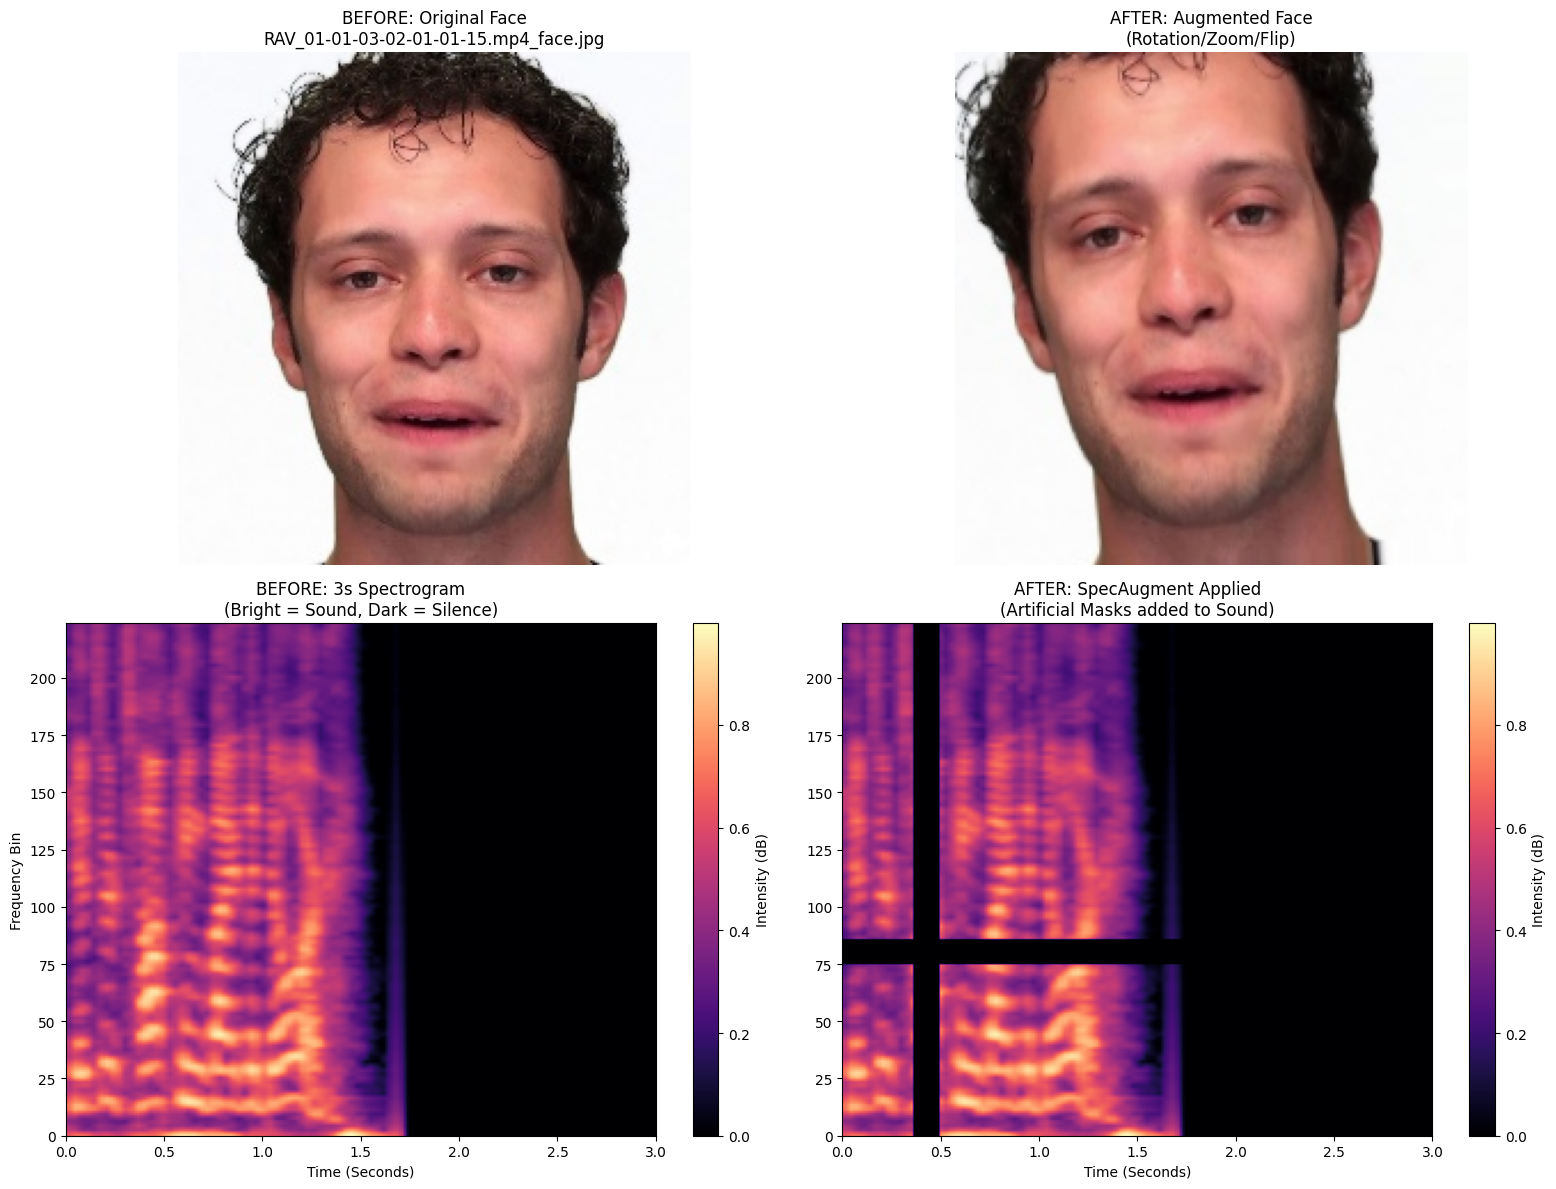

In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.efficientnet import preprocess_input as eff_preprocess

# ---------------------------------------------------------
# 1. SETUP AUGMENTATIONS (Using your exact parameters)
# ---------------------------------------------------------

# Image Augmentation (ImageDataGenerator)
visual_datagen = ImageDataGenerator(
    preprocessing_function=eff_preprocess,
    rotation_range=15,
    width_shift_range=0.15,
    height_shift_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Audio SpecAugment Function 
def visualize_augment_spectrogram(data):
    """
    Applies Time and Frequency masking. 
    Uses the minimum value of the data to mask so it looks like silence.
    """
    rows, cols, _ = data.shape
    aug_data = data.copy()
    silence_val = np.min(data) # The "Dark Purple" value
    
    # 1. Frequency Masking (Forced to 100% for visualization)
    f_len = np.random.randint(8, 15) 
    f0 = np.random.randint(0, rows - f_len)
    aug_data[f0:f0+f_len, :, :] = silence_val 

    # 2. Time Masking (Forced to 100% for visualization)
    t_len = np.random.randint(8, 15)
    t0 = np.random.randint(0, cols - t_len)
    aug_data[:, t0:t0+t_len, :] = silence_val
        
    return aug_data

# ---------------------------------------------------------
# 2. RUN VISUALIZATION 
# ---------------------------------------------------------

try:
    # Index 0 takes the first sample. Change this to see other files.
    sample_idx = 7020
    face_path = train_df.iloc[sample_idx]['face_path']
    audio_path = train_aud.iloc[sample_idx]['audio_path']

    # --- Process Image ---
    img = cv2.imread(face_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_resized = cv2.resize(img, (224, 224))
    
    img_batch = img_resized.reshape((1,) + img_resized.shape)
    aug_img_batch = visual_datagen.flow(img_batch, batch_size=1)[0]
    aug_img = aug_img_batch[0]

    # --- Process Audio ---
    spec = np.load(audio_path)
    aug_spec = visualize_augment_spectrogram(spec)

    # --- Plotting ---
    plt.figure(figsize=(16, 12))
    COLOR_MAP = 'magma' 
    # This maps the 224 pixels to a 0-3.0 second scale
    time_extent = [0, 3, 0, 224] 

    # Row 1: Face Images
    plt.subplot(2, 2, 1)
    plt.title(f"BEFORE: Original Face\n{os.path.basename(face_path)}")
    plt.imshow(img_resized.astype('uint8'))
    plt.axis('off')

    plt.subplot(2, 2, 2)
    plt.title("AFTER: Augmented Face\n(Rotation/Zoom/Flip)")
    plt.imshow(aug_img.astype('uint8'))
    plt.axis('off')

    # Row 2: Spectrograms
    plt.subplot(2, 2, 3)
    plt.title("BEFORE: 3s Spectrogram\n(Bright = Sound, Dark = Silence)")
    im1 = plt.imshow(spec[:,:,0], origin='lower', aspect='auto', cmap=COLOR_MAP, extent=time_extent)
    plt.colorbar(im1, label='Intensity (dB)')
    plt.xlabel("Time (Seconds)")
    plt.ylabel("Frequency Bin")

    plt.subplot(2, 2, 4)
    plt.title("AFTER: SpecAugment Applied\n(Artificial Masks added to Sound)")
    im2 = plt.imshow(aug_spec[:,:,0], origin='lower', aspect='auto', cmap=COLOR_MAP, extent=time_extent)
    plt.colorbar(im2, label='Intensity (dB)')
    plt.xlabel("Time (Seconds)")

    plt.tight_layout()
    plt.show()

except NameError as e:
    print(f"Error: {e}. Ensure you have run the cells that define 'train_df' and 'train_aud'.")
except Exception as e:
    print(f"An error occurred: {e}")

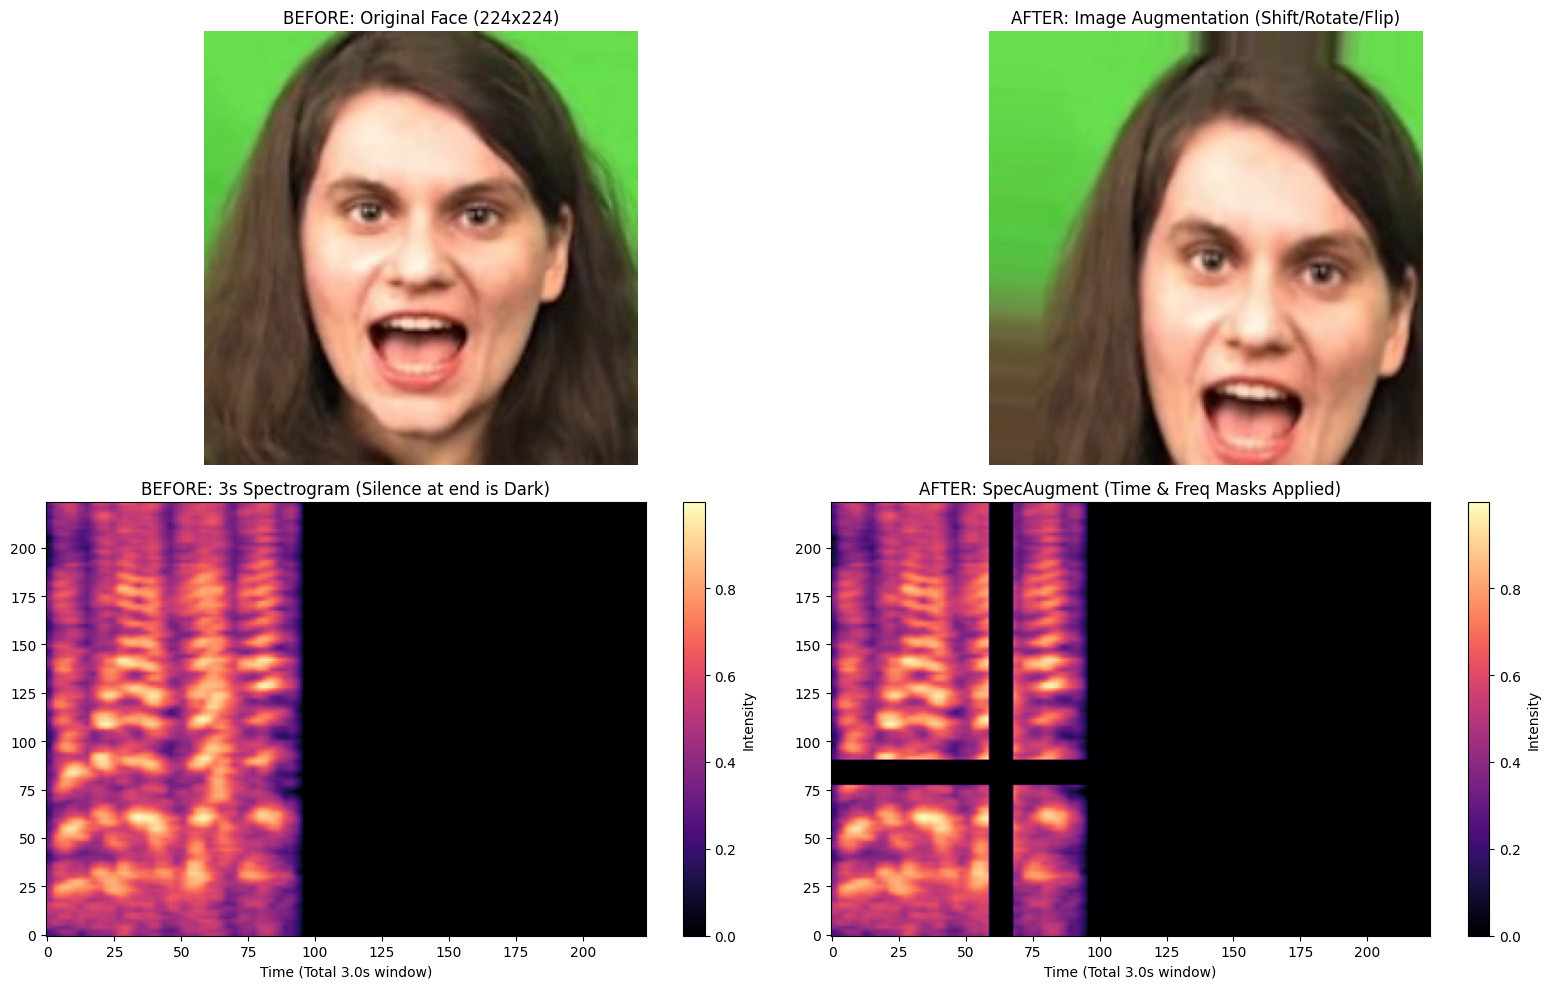

In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.efficientnet import preprocess_input as eff_preprocess

# ---------------------------------------------------------
# 1. SETUP AUGMENTATIONS
# ---------------------------------------------------------

# Image Augmentation Setup
# Re-importing eff_preprocess here to prevent NameError
visual_datagen = ImageDataGenerator(
    preprocessing_function=eff_preprocess,
    rotation_range=15,
    width_shift_range=0.15,
    height_shift_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Audio SpecAugment Function
def visualize_augment_spectrogram(data):
    """
    Applies Time and Frequency masking. 
    Uses np.min(data) so the masks match the silence color.
    """
    rows, cols, _ = data.shape
    aug_data = data.copy()
    silence_val = np.min(data) # This is the "Dark Purple" value
    
    # 1. Frequency Masking (Force 100% chance for this demo)
    f_len = np.random.randint(8, 15) 
    f0 = np.random.randint(0, rows - f_len)
    aug_data[f0:f0+f_len, :, :] = silence_val 

    # 2. Time Masking (Force 100% chance for this demo)
    t_len = np.random.randint(8, 15)
    t0 = np.random.randint(0, cols - t_len)
    aug_data[:, t0:t0+t_len, :] = silence_val
        
    return aug_data

# ---------------------------------------------------------
# 2. RUN VISUALIZATION 
# ---------------------------------------------------------

try:
    # Pick the first sample from your dataframes
    sample_idx = 0 
    face_path = train_df.iloc[sample_idx]['face_path']
    audio_path = train_aud.iloc[sample_idx]['audio_path']

    # --- Process Image ---
    img = cv2.imread(face_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_resized = cv2.resize(img, (224, 224))
    
    # Generate Augmented Image
    img_batch = img_resized.reshape((1,) + img_resized.shape)
    # The generator returns a batch, we take the first image [0]
    aug_img = visual_datagen.flow(img_batch, batch_size=1)[0][0]

    # --- Process Audio ---
    spec = np.load(audio_path)
    aug_spec = visualize_augment_spectrogram(spec)

    # --- Plotting ---
    plt.figure(figsize=(16, 10))
    COLOR_MAP = 'magma' # Best for seeing sound energy vs silence

    # Row 1: Faces
    plt.subplot(2, 2, 1)
    plt.title("BEFORE: Original Face (224x224)")
    plt.imshow(img_resized.astype('uint8'))
    plt.axis('off')

    plt.subplot(2, 2, 2)
    plt.title("AFTER: Image Augmentation (Shift/Rotate/Flip)")
    plt.imshow(aug_img.astype('uint8'))
    plt.axis('off')

    # Row 2: Spectrograms
    plt.subplot(2, 2, 3)
    plt.title("BEFORE: 3s Spectrogram (Silence at end is Dark)")
    plt.imshow(spec[:,:,0], origin='lower', aspect='auto', cmap=COLOR_MAP)
    plt.colorbar(label='Intensity')
    plt.xlabel("Time (Total 3.0s window)")

    plt.subplot(2, 2, 4)
    plt.title("AFTER: SpecAugment (Time & Freq Masks Applied)")
    plt.imshow(aug_spec[:,:,0], origin='lower', aspect='auto', cmap=COLOR_MAP)
    plt.colorbar(label='Intensity')
    plt.xlabel("Time (Total 3.0s window)")

    plt.tight_layout()
    plt.show()

except NameError as e:
    print(f"Error: {e}. Make sure 'train_df' and 'train_aud' cells were run after the crash.")
except Exception as e:
    print(f"An error occurred: {e}")

### Audio Model Builder

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D, LSTM, Bidirectional, Reshape, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.applications import EfficientNetB0, ResNet50, Xception
from tensorflow.keras.regularizers import l2

tf.keras.backend.clear_session()
NUM_CLASSES = 7
AUDIO_IMG_SIZE = (224, 224)
EMOTIONS = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

def visualize_training(history, model, test_gen, name):
    print(f"\nVisualizing Performance for {name}...")
    
    # 1. Loss & Accuracy Curves
    fig, ax = plt.subplots(1, 2, figsize=(14, 5))
    ax[0].plot(history.history['loss'], label='Train Loss', color='blue')
    ax[0].plot(history.history['val_loss'], label='Val Loss', color='orange')
    ax[0].set_title(f'{name} Loss'); ax[0].legend(); ax[0].grid(True)
    
    ax[1].plot(history.history['accuracy'], label='Train Acc', color='green')
    ax[1].plot(history.history['val_accuracy'], label='Val Acc', color='red')
    ax[1].set_title(f'{name} Accuracy'); ax[1].legend(); ax[1].grid(True)
    plt.tight_layout(); plt.show()

    # 2. Prediction Logic (Fixed for Generators without .reset)
    if hasattr(test_gen, 'reset'):
        test_gen.reset()
        
    preds = model.predict(test_gen, verbose=1)
    y_pred = np.argmax(preds, axis=1)
    
    # Get True Labels safely
    if hasattr(test_gen, 'classes'):
        y_true = test_gen.classes
    else:
        y_true = []
        if hasattr(test_gen, 'reset'): 
            test_gen.reset()  
        for i in range(len(test_gen)):
            _, batch_y = test_gen[i]
            y_true.extend(np.argmax(batch_y, axis=1))
        y_true = np.array(y_true)
            
    # 3. Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=EMOTIONS, yticklabels=EMOTIONS)
    plt.title(f'{name} Confusion Matrix')
    plt.ylabel('True Class'); plt.xlabel('Predicted Class'); plt.show()
    print(classification_report(y_true, y_pred, target_names=EMOTIONS))

def get_simple_baseline(input_shape, num_classes, name="Baseline_CNN"):
    inp = Input(shape=input_shape)
    x = Conv2D(32, (3,3), activation='relu', padding='same')(inp); x = MaxPooling2D((2,2))(x); x = Dropout(0.25)(x)
    x = Conv2D(64, (3,3), activation='relu', padding='same')(x); x = MaxPooling2D((2,2))(x); x = Dropout(0.25)(x)
    x = Conv2D(128, (3,3), activation='relu', padding='same')(x); x = MaxPooling2D((2,2))(x); x = Dropout(0.25)(x)
    x = Flatten()(x); x = Dense(64, activation='relu')(x); x = Dropout(0.5)(x)
    out = Dense(num_classes, activation='softmax')(x)
    return Model(inp, out, name=name)

def get_audio_efficientnet(input_shape, num_classes):
    base = EfficientNetB0(weights='imagenet', include_top=False, input_shape=input_shape)
    base.trainable = True
    for layer in base.layers[:-50]: layer.trainable = False 
    
    x = GlobalAveragePooling2D()(base.output)
    x = BatchNormalization()(x) 
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    out = Dense(num_classes, activation='softmax')(x)
    return Model(base.input, out, name="Audio_EfficientNet")

def get_audio_resnet(input_shape, num_classes):
    base = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
    base.trainable = True
    for layer in base.layers[:-40]: layer.trainable = False
    x = GlobalAveragePooling2D()(base.output); x = Dense(256, activation='relu')(x); x = Dropout(0.5)(x)
    out = Dense(num_classes, activation='softmax')(x)
    return Model(base.input, out, name="Audio_ResNet50")

def get_audio_cnn_lstm(input_shape, num_classes):
    inp = Input(shape=input_shape)
    x = Conv2D(64, (3,3), padding='same', activation='relu')(inp); x = MaxPooling2D((2,2))(x)
    x = Conv2D(128, (3,3), padding='same', activation='relu')(x); x = MaxPooling2D((2,2))(x)
    x = Conv2D(256, (3,3), padding='same', activation='relu')(x); x = MaxPooling2D((2,2))(x)
    x = Reshape((28, -1))(x) 
    x = Bidirectional(LSTM(128, return_sequences=False))(x); x = Dropout(0.4)(x)
    out = Dense(num_classes, activation='softmax')(x)
    return Model(inp, out, name="Audio_CRNN_LSTM")

def get_face_transfer_model(base_arch, input_shape, num_classes, name):
    base = base_arch(weights='imagenet', include_top=False, input_shape=input_shape)
    base.trainable = False 
    x = GlobalAveragePooling2D()(base.output)
    x = BatchNormalization()(x)  
    x = Dense(512, activation='relu', kernel_regularizer=l2(0.001))(x)
    x = Dropout(0.6)(x)        
    out = Dense(num_classes, activation='softmax')(x)
    return Model(base.input, out, name=name)

In [ ]:
import gc
from tensorflow.keras.layers import Flatten
import time

CNN

Training Audio_Baseline_CNN...
Epoch 1/20
498/498 ━━━━━━━━━━━━━━━━━━━━ 183s 366ms/step - accuracy: 0.1785 - loss: 1.9109 - val_accuracy: 0.2595 - val_loss: 1.9021
Epoch 2/20
498/498 ━━━━━━━━━━━━━━━━━━━━ 184s 369ms/step - accuracy: 0.1932 - loss: 1.8466 - val_accuracy: 0.1946 - val_loss: 1.9031
Epoch 3/20
498/498 ━━━━━━━━━━━━━━━━━━━━ 210s 422ms/step - accuracy: 0.2182 - loss: 1.8000 - val_accuracy: 0.2358 - val_loss: 1.8454
Epoch 4/20
498/498 ━━━━━━━━━━━━━━━━━━━━ 206s 414ms/step - accuracy: 0.2330 - loss: 1.7690 - val_accuracy: 0.3131 - val_loss: 1.7931
Epoch 5/20
498/498 ━━━━━━━━━━━━━━━━━━━━ 209s 419ms/step - accuracy: 0.2486 - loss: 1.7388 - val_accuracy: 0.3223 - val_loss: 1.7677
Epoch 6/20
498/498 ━━━━━━━━━━━━━━━━━━━━ 210s 421ms/step - accuracy: 0.2697 - loss: 1.7009 - val_accuracy: 0.3687 - val_loss: 1.7062
Epoch 7/20
498/498 ━━━━━━━━━━━━━━━━━━━━ 222s 447ms/step - accuracy: 0.2811 - loss: 1.6688 - val_accuracy: 0.3780 - val_loss: 1.6426
Epoch 8/20
498/498 ━━━━━━━━━━━━━━━━━━━━ 208s 

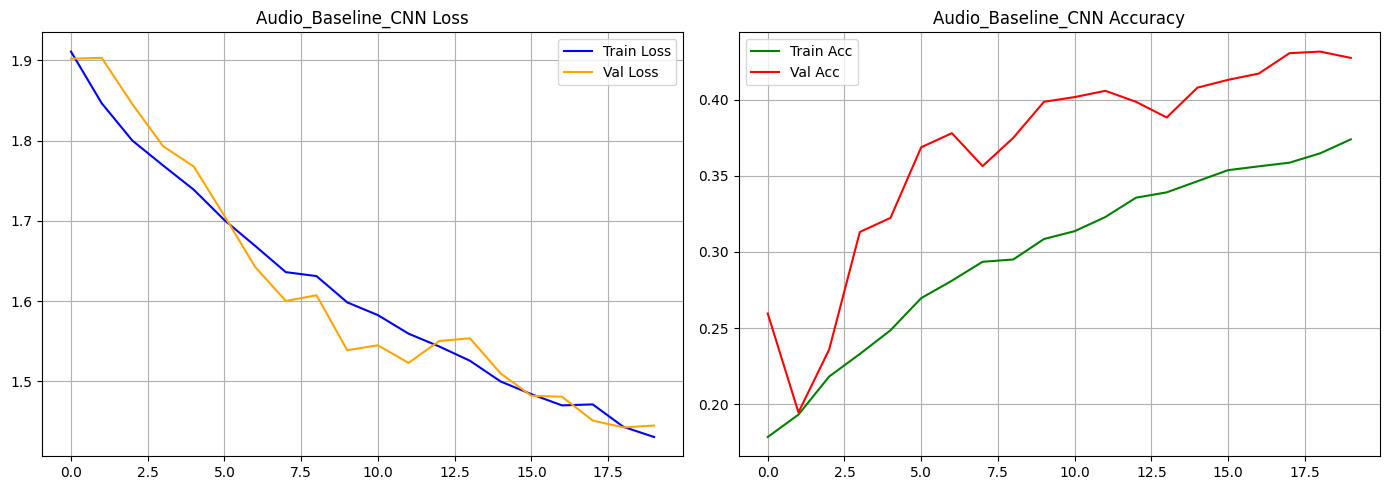

64/64 ━━━━━━━━━━━━━━━━━━━━ 6s 96ms/step


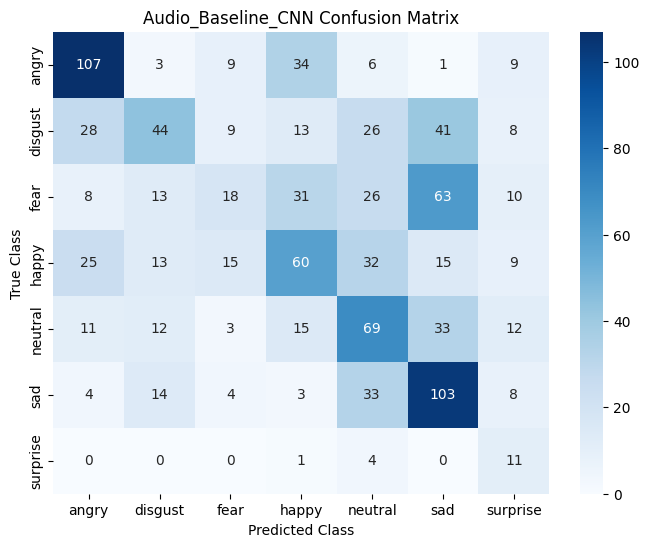

              precision    recall  f1-score   support

       angry       0.58      0.63      0.61       169
     disgust       0.44      0.26      0.33       169
        fear       0.31      0.11      0.16       169
       happy       0.38      0.36      0.37       169
     neutral       0.35      0.45      0.39       155
         sad       0.40      0.61      0.48       169
    surprise       0.16      0.69      0.27        16

    accuracy                           0.41      1016
   macro avg       0.38      0.44      0.37      1016
weighted avg       0.41      0.41      0.39      1016



In [ ]:
tf.keras.backend.clear_session()
import gc
gc.collect()

from tensorflow.keras.layers import Flatten

def get_simple_baseline(input_shape, num_classes, name="Baseline_CNN"):
    inp = Input(shape=input_shape)
    x = Conv2D(32, (3,3), activation='relu', padding='same')(inp); x = MaxPooling2D((2,2))(x); x = Dropout(0.25)(x)
    x = Conv2D(64, (3,3), activation='relu', padding='same')(x); x = MaxPooling2D((2,2))(x); x = Dropout(0.25)(x)
    x = Conv2D(128, (3,3), activation='relu', padding='same')(x); x = MaxPooling2D((2,2))(x); x = Dropout(0.25)(x)
    x = Flatten()(x); x = Dense(64, activation='relu')(x); x = Dropout(0.5)(x)
    out = Dense(num_classes, activation='softmax')(x)
    return Model(inp, out, name=name)

NAME = "Audio_Baseline_CNN"
print(f"Training {NAME}...")

train_gen = NpyDataGenerator(train_aud, eff_preprocess, batch_size=16)
val_gen = NpyDataGenerator(val_aud, eff_preprocess, batch_size=16, shuffle=False)
test_gen = NpyDataGenerator(test_aud, eff_preprocess, batch_size=16, shuffle=False)

model = get_simple_baseline(AUDIO_IMG_SIZE+(3,), NUM_CLASSES, NAME)
model.compile(optimizer=Adam(1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

callbacks = [
    EarlyStopping(patience=5, restore_best_weights=True),
    ModelCheckpoint(f"models_zoo_1/{NAME}.keras", save_best_only=True, monitor='val_accuracy')
]

print("Starting Training...")
start_train = time.time()
hist = model.fit(
    train_gen, 
    validation_data=val_gen, 
    epochs=20, 
    callbacks=callbacks, 
    class_weight=class_weights_dict,  
    verbose=1
)
end_train = time.time()    
total_train_minutes = (end_train - start_train) / 60

print(f"Total Training Time: {total_train_minutes:.2f} minutes")

model.load_weights(f"models_zoo_1/{NAME}.keras")
visualize_training(hist, model, test_gen, NAME)

EfficientNet

Training Audio_EfficientNet...
Epoch 1/20
498/498 ━━━━━━━━━━━━━━━━━━━━ 219s 421ms/step - accuracy: 0.2762 - loss: 2.1555 - val_accuracy: 0.4428 - val_loss: 1.6415
Epoch 2/20
498/498 ━━━━━━━━━━━━━━━━━━━━ 224s 450ms/step - accuracy: 0.3646 - loss: 1.7335 - val_accuracy: 0.4634 - val_loss: 1.5872
Epoch 3/20
498/498 ━━━━━━━━━━━━━━━━━━━━ 223s 447ms/step - accuracy: 0.3944 - loss: 1.5757 - val_accuracy: 0.4871 - val_loss: 1.4463
Epoch 4/20
498/498 ━━━━━━━━━━━━━━━━━━━━ 223s 448ms/step - accuracy: 0.4401 - loss: 1.4361 - val_accuracy: 0.4933 - val_loss: 1.3992
Epoch 5/20
498/498 ━━━━━━━━━━━━━━━━━━━━ 204s 411ms/step - accuracy: 0.4637 - loss: 1.3634 - val_accuracy: 0.5170 - val_loss: 1.3840
Epoch 6/20
498/498 ━━━━━━━━━━━━━━━━━━━━ 238s 478ms/step - accuracy: 0.4927 - loss: 1.2861 - val_accuracy: 0.5221 - val_loss: 1.3983
Epoch 7/20
498/498 ━━━━━━━━━━━━━━━━━━━━ 232s 466ms/step - accuracy: 0.5116 - loss: 1.2361 - val_accuracy: 0.4954 - val_loss: 1.4256
Epoch 8/20
498/498 ━━━━━━━━━━━━━━━━━━━━ 196s 

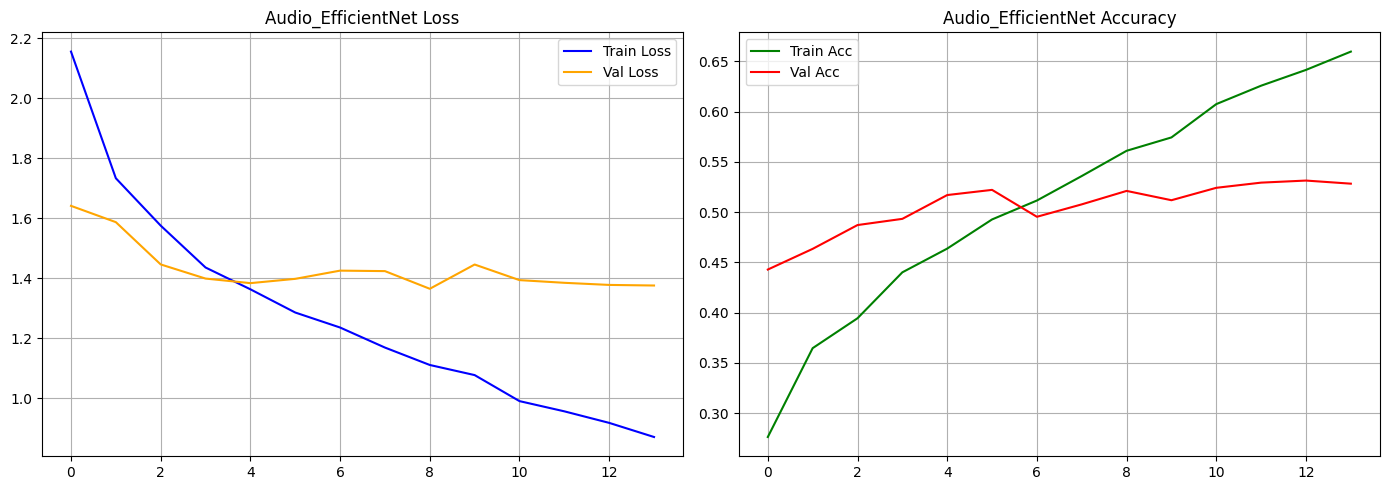

64/64 ━━━━━━━━━━━━━━━━━━━━ 20s 276ms/step


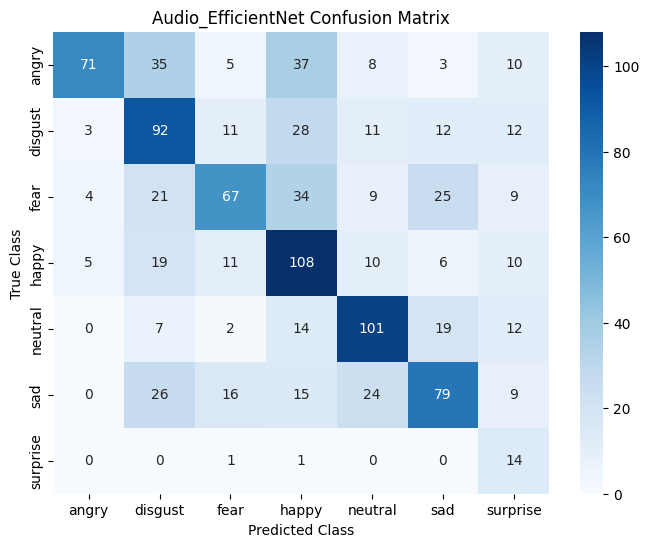

              precision    recall  f1-score   support

       angry       0.86      0.42      0.56       169
     disgust       0.46      0.54      0.50       169
        fear       0.59      0.40      0.48       169
       happy       0.46      0.64      0.53       169
     neutral       0.62      0.65      0.64       155
         sad       0.55      0.47      0.50       169
    surprise       0.18      0.88      0.30        16

    accuracy                           0.52      1016
   macro avg       0.53      0.57      0.50      1016
weighted avg       0.58      0.52      0.53      1016



In [ ]:
tf.keras.backend.clear_session()
import gc
gc.collect()

NAME = "Audio_EfficientNet"
print(f"Training {NAME}...")

# Ensures spectrograms (0-1) are scaled to (0-255) before EfficientNet sees them.
def audio_preprocess_wrapper(img):  
    img = img * 255.0
    return eff_preprocess(img)

train_gen = NpyDataGenerator(train_aud, audio_preprocess_wrapper, batch_size=16)
val_gen = NpyDataGenerator(val_aud, audio_preprocess_wrapper, batch_size=16, shuffle=False)
test_gen = NpyDataGenerator(test_aud, audio_preprocess_wrapper, batch_size=16, shuffle=False)

model = get_audio_efficientnet(AUDIO_IMG_SIZE+(3,), NUM_CLASSES)
model.compile(optimizer=Adam(1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

callbacks = [
    EarlyStopping(patience=5, restore_best_weights=True), 
    ModelCheckpoint(f"models_zoo_1/{NAME}.keras", save_best_only=True, monitor='val_accuracy')
]
print("Starting Training...")
start_train = time.time()

hist = model.fit(
    train_gen, 
    validation_data=val_gen, 
    epochs=20, 
    callbacks=callbacks, 
    class_weight=class_weights_dict, 
    verbose=1
)

end_train = time.time()    
total_train_minutes = (end_train - start_train) / 60

print(f"Total Training Time: {total_train_minutes:.2f} minutes")

model.load_weights(f"models_zoo_1/{NAME}.keras")
visualize_training(hist, model, test_gen, NAME)

EfficientNet Baseline

In [ ]:
def get_audio_efficientnet(input_shape, num_classes):
    base = EfficientNetB0(weights='imagenet', include_top=False, input_shape=input_shape)
    base.trainable = True
    for layer in base.layers[:-50]: layer.trainable = False 
    x = GlobalAveragePooling2D()(base.output); x = Dense(256, activation='relu')(x); x = Dropout(0.5)(x)
    out = Dense(num_classes, activation='softmax')(x)
    return Model(base.input, out, name="Audio_EfficientNet_1")

In [ ]:
tf.keras.backend.clear_session()
import gc
gc.collect()

NAME = "Audio_EfficientNet_1"
print(f"Training {NAME}...")

def audio_preprocess_wrapper(img):
    img = img * 255.0
    return eff_preprocess(img)

train_gen = NpyDataGenerator(train_aud, audio_preprocess_wrapper, batch_size=16)
val_gen = NpyDataGenerator(val_aud, audio_preprocess_wrapper, batch_size=16, shuffle=False)
test_gen = NpyDataGenerator(test_aud, audio_preprocess_wrapper, batch_size=16, shuffle=False)

model = get_audio_efficientnet(AUDIO_IMG_SIZE+(3,), NUM_CLASSES)
model.compile(optimizer=Adam(1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

callbacks = [
    EarlyStopping(patience=5, restore_best_weights=True), 
    ModelCheckpoint(f"models_zoo_1/{NAME}_1.keras", save_best_only=True, monitor='val_accuracy')
]

hist = model.fit(
    train_gen, 
    validation_data=val_gen, 
    epochs=20, 
    callbacks=callbacks, 
    class_weight=class_weights_dict, 
    verbose=1
)

model.load_weights(f"models_zoo_1/{NAME}_1.keras")
visualize_training(hist, model, test_gen, NAME)

ResNet50 Baseline (Wrong Input Size)

Training Audio_ResNet50...
Epoch 1/20
498/498 ━━━━━━━━━━━━━━━━━━━━ 664s 1s/step - accuracy: 0.2388 - loss: 1.8329 - val_accuracy: 0.1864 - val_loss: 1.8363
Epoch 2/20
498/498 ━━━━━━━━━━━━━━━━━━━━ 649s 1s/step - accuracy: 0.2928 - loss: 1.6979 - val_accuracy: 0.3141 - val_loss: 1.7215
Epoch 3/20
498/498 ━━━━━━━━━━━━━━━━━━━━ 678s 1s/step - accuracy: 0.3264 - loss: 1.6133 - val_accuracy: 0.1792 - val_loss: 2.3178
Epoch 4/20
498/498 ━━━━━━━━━━━━━━━━━━━━ 754s 2s/step - accuracy: 0.3391 - loss: 1.5822 - val_accuracy: 0.2513 - val_loss: 1.7304
Epoch 5/20
498/498 ━━━━━━━━━━━━━━━━━━━━ 698s 1s/step - accuracy: 0.3603 - loss: 1.5254 - val_accuracy: 0.3388 - val_loss: 1.6524
Epoch 6/20
498/498 ━━━━━━━━━━━━━━━━━━━━ 665s 1s/step - accuracy: 0.3630 - loss: 1.5192 - val_accuracy: 0.1318 - val_loss: 4.5314
Epoch 7/20
498/498 ━━━━━━━━━━━━━━━━━━━━ 647s 1s/step - accuracy: 0.3729 - loss: 1.5124 - val_accuracy: 0.2307 - val_loss: 2.9199
Epoch 8/20
498/498 ━━━━━━━━━━━━━━━━━━━━ 620s 1s/step - accuracy: 0.382

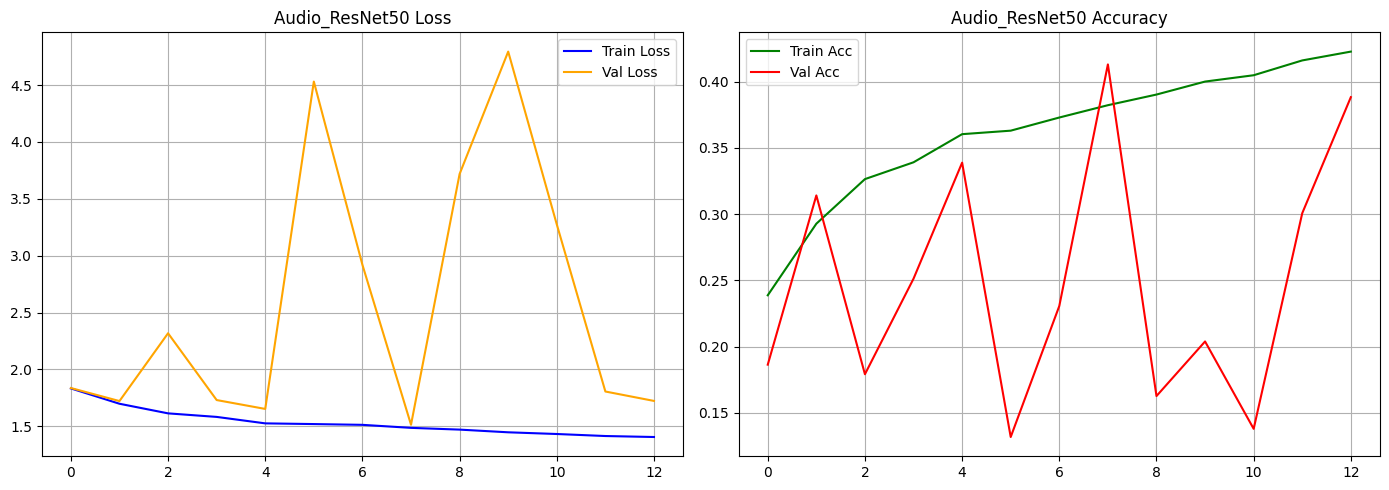

64/64 ━━━━━━━━━━━━━━━━━━━━ 52s 790ms/step


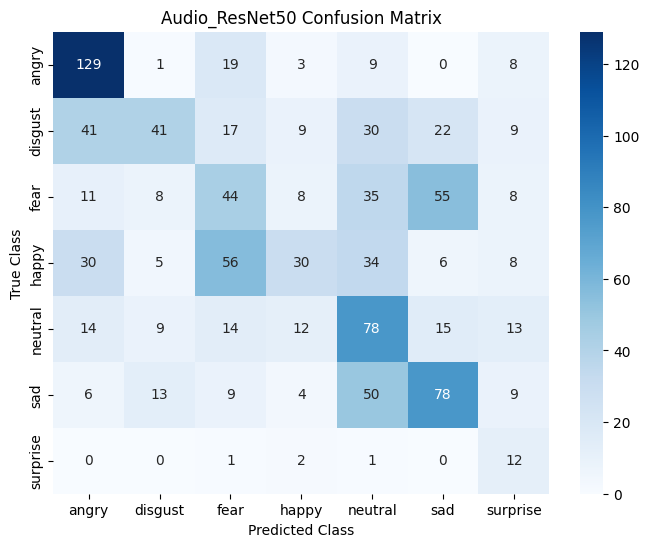

              precision    recall  f1-score   support

       angry       0.56      0.76      0.65       169
     disgust       0.53      0.24      0.33       169
        fear       0.28      0.26      0.27       169
       happy       0.44      0.18      0.25       169
     neutral       0.33      0.50      0.40       155
         sad       0.44      0.46      0.45       169
    surprise       0.18      0.75      0.29        16

    accuracy                           0.41      1016
   macro avg       0.39      0.45      0.38      1016
weighted avg       0.43      0.41      0.39      1016



In [ ]:
tf.keras.backend.clear_session(); gc.collect()
NAME = "Audio_ResNet50"
print(f"Training {NAME}...")

train_gen = NpyDataGenerator(train_aud, res_preprocess, batch_size=16)
val_gen = NpyDataGenerator(val_aud, res_preprocess, batch_size=16, shuffle=False)
test_gen = NpyDataGenerator(test_aud, res_preprocess, batch_size=16, shuffle=False)

model = get_audio_resnet(AUDIO_IMG_SIZE+(3,), NUM_CLASSES)
model.compile(optimizer=Adam(1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

callbacks = [EarlyStopping(patience=5, restore_best_weights=True), ModelCheckpoint(f"models_zoo_1/{NAME}.keras", save_best_only=True, monitor='val_accuracy')]
print("Starting Training...")
start_train = time.time()

hist = model.fit(train_gen, validation_data=val_gen, epochs=20, callbacks=callbacks, class_weight=class_weights_dict, verbose=1)

end_train = time.time()    
total_train_minutes = (end_train - start_train) / 60

print(f"Total Training Time: {total_train_minutes:.2f} minutes")

model.load_weights(f"models_zoo_1/{NAME}.keras")
visualize_training(hist, model, test_gen, NAME)

ResNet50 (Fixed)

In [6]:
# 1. Define the missing variable
label_col = 'label' # or 'label_str', check your audio dataframe columns

# 2. Now the generators will work
train_gen = NpyDataGenerator(train_aud, resnet_preprocess_wrapper, batch_size=16)
val_gen = NpyDataGenerator(val_aud, resnet_preprocess_wrapper, batch_size=16, shuffle=False)
test_gen = NpyDataGenerator(test_aud, resnet_preprocess_wrapper, batch_size=16, shuffle=False)

Training Audio_ResNet50_1...
Starting Training...
Epoch 1/20


c:\Users\User\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


498/498 ━━━━━━━━━━━━━━━━━━━━ 1019s 2s/step - accuracy: 0.3731 - loss: 1.5488 - val_accuracy: 0.4449 - val_loss: 1.4103
Epoch 2/20
498/498 ━━━━━━━━━━━━━━━━━━━━ 969s 2s/step - accuracy: 0.4863 - loss: 1.2845 - val_accuracy: 0.5026 - val_loss: 1.3226
Epoch 3/20
498/498 ━━━━━━━━━━━━━━━━━━━━ 967s 2s/step - accuracy: 0.5551 - loss: 1.1153 - val_accuracy: 0.5232 - val_loss: 1.2336
Epoch 4/20
498/498 ━━━━━━━━━━━━━━━━━━━━ 1047s 2s/step - accuracy: 0.6382 - loss: 0.9234 - val_accuracy: 0.4809 - val_loss: 1.4040
Epoch 5/20
498/498 ━━━━━━━━━━━━━━━━━━━━ 971s 2s/step - accuracy: 0.7094 - loss: 0.7513 - val_accuracy: 0.5057 - val_loss: 1.4136
Epoch 6/20
498/498 ━━━━━━━━━━━━━━━━━━━━ 961s 2s/step - accuracy: 0.7649 - loss: 0.6172 - val_accuracy: 0.5324 - val_loss: 1.3729
Epoch 7/20
498/498 ━━━━━━━━━━━━━━━━━━━━ 122018s 246s/step - accuracy: 0.7973 - loss: 0.5380 - val_accuracy: 0.5263 - val_loss: 1.8857
Epoch 8/20
498/498 ━━━━━━━━━━━━━━━━━━━━ 1377s 3s/step - accuracy: 0.8185 - loss: 0.4764 - val_accurac

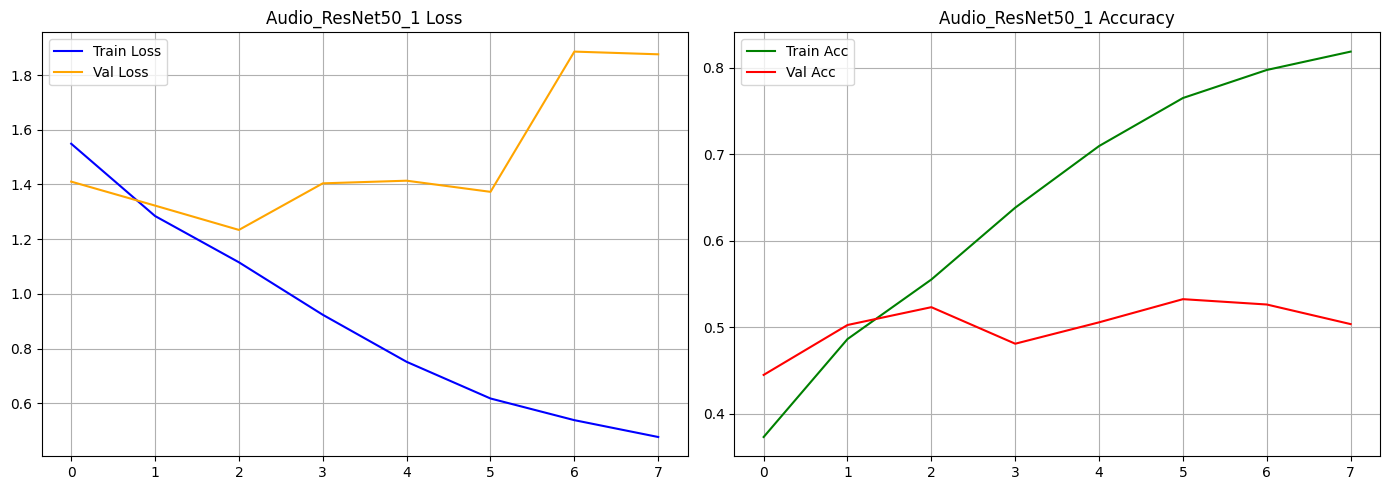

64/64 ━━━━━━━━━━━━━━━━━━━━ 93s 1s/step


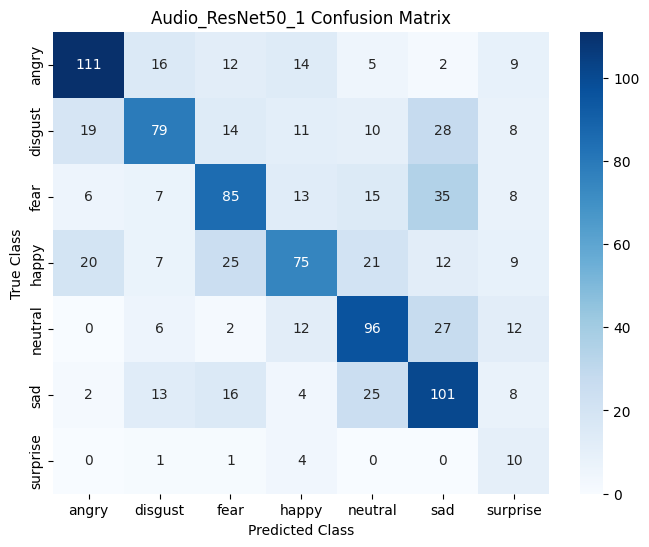

              precision    recall  f1-score   support

       angry       0.70      0.66      0.68       169
     disgust       0.61      0.47      0.53       169
        fear       0.55      0.50      0.52       169
       happy       0.56      0.44      0.50       169
     neutral       0.56      0.62      0.59       155
         sad       0.49      0.60      0.54       169
    surprise       0.16      0.62      0.25        16

    accuracy                           0.55      1016
   macro avg       0.52      0.56      0.52      1016
weighted avg       0.57      0.55      0.55      1016



In [9]:
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.resnet50 import preprocess_input as res_preprocess
import numpy as np
import time
import gc

# Ensure your label column is defined for the DataGenerator
label_col = 'label' # or 'label_str'

tf.keras.backend.clear_session()
gc.collect()

NAME = "Audio_ResNet50_1"
print(f"Training {NAME}...")

# ResNet expects 0-255 inputs because it performs mean subtraction.
def resnet_preprocess_wrapper(img):
    img = img * 255.0
    return res_preprocess(img)

train_gen = NpyDataGenerator(train_aud, resnet_preprocess_wrapper, batch_size=16)
val_gen = NpyDataGenerator(val_aud, resnet_preprocess_wrapper, batch_size=16, shuffle=False)
test_gen = NpyDataGenerator(test_aud, resnet_preprocess_wrapper, batch_size=16, shuffle=False)

model = get_audio_resnet(AUDIO_IMG_SIZE+(3,), NUM_CLASSES)
model.compile(optimizer=Adam(1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

callbacks = [
    EarlyStopping(patience=5, restore_best_weights=True), 
    ModelCheckpoint(f"models_zoo_1/{NAME}_1.keras", save_best_only=True, monitor='val_accuracy')
]

print("Starting Training...")
start_train = time.time()

hist = model.fit(
    train_gen, 
    validation_data=val_gen, 
    epochs=20, 
    callbacks=callbacks, 
    class_weight=class_weights_dict, 
    verbose=1
)

end_train = time.time()
total_train_minutes = (end_train - start_train) / 60

print(f"Total Training Time: {total_train_minutes:.2f} minutes")

model.load_weights(f"models_zoo_1/{NAME}_1.keras")
visualize_training(hist, model, test_gen, NAME)

In [12]:
from sklearn.utils import resample
import pandas as pd

# 1. Identify the label column
target_col = 'label' 

# 2. Separate the minority class (surprise) from the rest
df_surprise = train_df[train_df[target_col] == 'surprise'] 
df_others = train_df[train_df[target_col] != 'surprise']

# Calculate the target number (size of the largest class in the 'others' group)
# This will be roughly 1280 based on your output
majority_count = df_others[target_col].value_counts().max()

print(f"Original Surprise count: {len(df_surprise)}")
print(f"Targeting majority count: {majority_count}")

# 3. Upsample 'surprise' to match the majority count
df_surprise_upsampled = resample(df_surprise, 
                                 replace=True,        # Sample with replacement
                                 n_samples=majority_count, # <--- USE CALCULATED MAX HERE
                                 random_state=42) 

# 4. Combine back together
train_df_balanced = pd.concat([df_others, df_surprise_upsampled])

# 5. Shuffle
train_df_balanced = train_df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

print("\nCorrected Class Distribution:")
print(train_df_balanced[target_col].value_counts())

Original Surprise count: 288
Targeting majority count: 1280

Corrected Class Distribution:
label
fear        1280
neutral     1280
surprise    1280
angry       1279
disgust     1279
sad         1279
happy       1277
Name: count, dtype: int64


Training Audio_ResNet50_Augmented_Balanced...
Balancing Training Data...
 - Original Surprise count: 288
 - Target Majority count: 1280
 - New Training Size: 8954
 - Class distribution in Training:
label
fear        1280
neutral     1280
surprise    1280
angry       1279
disgust     1279
sad         1279
happy       1277
Name: count, dtype: int64
Starting Training...
Epoch 1/20


c:\Users\User\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


560/560 ━━━━━━━━━━━━━━━━━━━━ 1119s 2s/step - accuracy: 0.4052 - loss: 1.5848 - val_accuracy: 0.4233 - val_loss: 1.4531
Epoch 2/20
560/560 ━━━━━━━━━━━━━━━━━━━━ 1083s 2s/step - accuracy: 0.5015 - loss: 1.3599 - val_accuracy: 0.4377 - val_loss: 1.4023
Epoch 3/20
560/560 ━━━━━━━━━━━━━━━━━━━━ 1083s 2s/step - accuracy: 0.5474 - loss: 1.2349 - val_accuracy: 0.5098 - val_loss: 1.3323
Epoch 4/20
560/560 ━━━━━━━━━━━━━━━━━━━━ 1067s 2s/step - accuracy: 0.5878 - loss: 1.1360 - val_accuracy: 0.5458 - val_loss: 1.2154
Epoch 5/20
560/560 ━━━━━━━━━━━━━━━━━━━━ 1040s 2s/step - accuracy: 0.6283 - loss: 1.0361 - val_accuracy: 0.4964 - val_loss: 1.3434
Epoch 6/20
560/560 ━━━━━━━━━━━━━━━━━━━━ 1027s 2s/step - accuracy: 0.6609 - loss: 0.9486 - val_accuracy: 0.5438 - val_loss: 1.2950
Epoch 7/20
560/560 ━━━━━━━━━━━━━━━━━━━━ 1037s 2s/step - accuracy: 0.6960 - loss: 0.8536 - val_accuracy: 0.5345 - val_loss: 1.4166
Epoch 8/20
560/560 ━━━━━━━━━━━━━━━━━━━━ 1029s 2s/step - accuracy: 0.7268 - loss: 0.7720 - val_accurac

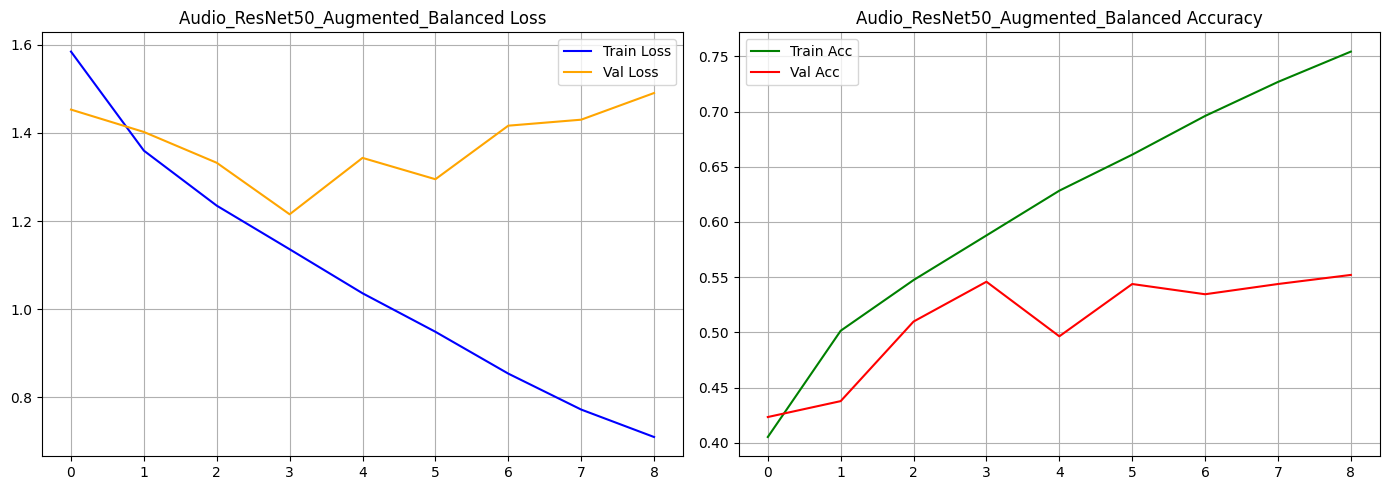

64/64 ━━━━━━━━━━━━━━━━━━━━ 78s 1s/step


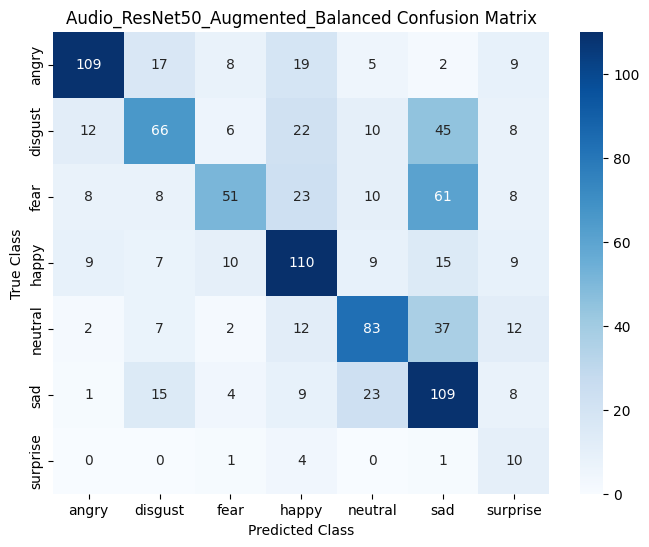

              precision    recall  f1-score   support

       angry       0.77      0.64      0.70       169
     disgust       0.55      0.39      0.46       169
        fear       0.62      0.30      0.41       169
       happy       0.55      0.65      0.60       169
     neutral       0.59      0.54      0.56       155
         sad       0.40      0.64      0.50       169
    surprise       0.16      0.62      0.25        16

    accuracy                           0.53      1016
   macro avg       0.52      0.54      0.50      1016
weighted avg       0.58      0.53      0.53      1016



In [14]:
import tensorflow as tf
import time
import gc
import numpy as np
import pandas as pd
import cv2  
from sklearn.utils import resample
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.resnet50 import preprocess_input as res_preprocess
from tensorflow.keras.utils import Sequence, to_categorical

# --- 1. SETUP & CLEANUP ---
tf.keras.backend.clear_session()
gc.collect()

NAME = "Audio_ResNet50_Augmented_Balanced"
print(f"Training {NAME}...")

# Variable definitions
label_col = 'label'  # Ensure this matches your column name

# --- 2. BALANCING THE TRAINING DATA (Crucial Step) ---
print("Balancing Training Data...")

# Separate the minority class
df_surprise = train_df[train_df[label_col] == 'surprise'] 
df_others = train_df[train_df[label_col] != 'surprise']

# Calculate the target count (the size of the biggest class in 'others')
majority_count = df_others[label_col].value_counts().max()
print(f" - Original Surprise count: {len(df_surprise)}")
print(f" - Target Majority count: {majority_count}")

# Upsample 'surprise' to match the majority
df_surprise_upsampled = resample(df_surprise, 
                                 replace=True,     # Sample with replacement
                                 n_samples=majority_count, 
                                 random_state=42) 

# Combine back together
train_df_balanced = pd.concat([df_others, df_surprise_upsampled])

# Shuffle the new dataframe
train_df_balanced = train_df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

print(f" - New Training Size: {len(train_df_balanced)}")
print(" - Class distribution in Training:")
print(train_df_balanced[label_col].value_counts())

# --- 3. CUSTOM GENERATOR ---
class NpyDataGenerator(Sequence):
    def __init__(self, df, preprocess_func, batch_size=16, target_size=(224,224), shuffle=True, is_image=False, augment=False):
        self.df = df
        self.batch_size = batch_size
        self.preprocess_func = preprocess_func
        self.target_size = target_size
        self.shuffle = shuffle
        self.is_image = is_image
        self.augment = augment
        self.indices = np.arange(len(df))
        # Note: Assumes 'le' (LabelEncoder) is already defined in your environment
        self.labels = le.transform(self.df[label_col]) 
        self.num_classes = len(le.classes_)
        self.on_epoch_end()

    def __len__(self): 
        return int(np.ceil(len(self.df) / self.batch_size))

    def _augment_spectrogram(self, data):
        """ Lightweight SpecAugment """
        rows, cols, _ = data.shape
        
        # 1. Frequency Masking
        if np.random.random() < 0.4:
            f_len = np.random.randint(2, 12) 
            f0 = np.random.randint(0, rows - f_len)
            data[f0:f0+f_len, :, :] = 0 

        # 2. Time Masking
        if np.random.random() < 0.4:
            t_len = np.random.randint(2, 12)
            t0 = np.random.randint(0, cols - t_len)
            data[:, t0:t0+t_len, :] = 0

        return data

    def __getitem__(self, index):
        idx_batch = self.indices[index * self.batch_size:(index + 1) * self.batch_size]
        X_batch, y_batch = [], []
        
        for i in idx_batch:
            row = self.df.iloc[i]
            path = row['face_path'] if self.is_image else row['audio_path']
            
            try:
                data = np.load(path)
                if data.shape[:2] != self.target_size:
                    data = cv2.resize(data, self.target_size)
                
                # Ensure 3 channels
                if len(data.shape) == 2:
                    data = np.stack([data]*3, axis=-1)
            except Exception:
                data = np.zeros(self.target_size + (3,))

            if self.augment:
                data = self._augment_spectrogram(data)

            data = self.preprocess_func(data)
            X_batch.append(data)
            y_batch.append(self.labels[i])
                
        return np.array(X_batch), to_categorical(y_batch, num_classes=self.num_classes)

    def on_epoch_end(self):
        if self.shuffle: np.random.shuffle(self.indices)

# --- 4. PREPROCESSING WRAPPER ---
def resnet_preprocess_wrapper(img):
    # ResNet needs 0-255 range. If your .npy is 0-1, this scales it up.
    img = img * 255.0
    return res_preprocess(img)

# --- 5. INITIALIZE GENERATORS ---
# Only train_gen uses the BALANCED and AUGMENTED data
train_gen = NpyDataGenerator(train_df_balanced, resnet_preprocess_wrapper, batch_size=16, augment=True)

# Validation and Test use original (IMBALANCED) data to reflect reality
val_gen = NpyDataGenerator(val_df, resnet_preprocess_wrapper, batch_size=16, shuffle=False, augment=False)
test_gen = NpyDataGenerator(test_df, resnet_preprocess_wrapper, batch_size=16, shuffle=False, augment=False)

# --- 6. MODEL SETUP & TRAINING ---
model = get_audio_resnet(AUDIO_IMG_SIZE+(3,), NUM_CLASSES)

model.compile(
    optimizer=Adam(1e-4), 
    loss='categorical_crossentropy', 
    metrics=['accuracy']
)

callbacks = [
    EarlyStopping(patience=5, restore_best_weights=True), 
    ModelCheckpoint(f"models_zoo_1/{NAME}.keras", save_best_only=True, monitor='val_accuracy')
]

print("Starting Training...")
start_train = time.time()

# NOTE: class_weight is REMOVED because we balanced the dataframe manually
hist = model.fit(
    train_gen, 
    validation_data=val_gen, 
    epochs=20, 
    callbacks=callbacks, 
    verbose=1
)

end_train = time.time()
print(f"Total Training Time: {(end_train - start_train) / 60:.2f} minutes")

# Visualization
model.load_weights(f"models_zoo_1/{NAME}.keras")
visualize_training(hist, model, test_gen, NAME)

In [15]:
import os
import shutil
import numpy as np
import pandas as pd
import tensorflow as tf
import cv2
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import Sequence
from sklearn.preprocessing import LabelEncoder

# --- 1. IMPORT PREPROCESSING ---
from tensorflow.keras.applications.efficientnet import preprocess_input as eff_preprocess
from tensorflow.keras.applications.resnet50 import preprocess_input as res_preprocess
from tensorflow.keras.applications.xception import preprocess_input as xcp_preprocess

# --- 2. CONFIGURATION & DATA LOADING ---
MODEL_DIR = "models_zoo_1"
DATA_DIR = r"C:\Users\User\Multimodel AI\data_1" 
BATCH_SIZE = 16

print("--- Loading Metadata ---")
test_df = pd.read_csv(os.path.join(DATA_DIR, "test_face.csv"))
test_aud = pd.read_csv(os.path.join(DATA_DIR, "test_audio.csv"))

# --- 3. FIX: ENCODE LABELS ---
le = LabelEncoder()
all_labels = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
le.fit(all_labels)

test_df['label_str'] = test_df['label'].astype(str)
test_df['label_encoded'] = le.transform(test_df['label_str'])

test_aud['label_str'] = test_aud['label'].astype(str)
test_aud['label_encoded'] = le.transform(test_aud['label_str'])

label_column = 'label_str'

# --- 4. AUDIO DATA GENERATOR ---
class NpyDataGenerator(Sequence):
    def __init__(self, df, preprocess_f, batch_size=16, target_size=(224,224), shuffle=False):
        self.df = df
        self.preprocess_f = preprocess_f
        self.batch_size = batch_size
        self.target_size = target_size
        self.indices = np.arange(len(self.df))
        self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(len(self.df) / self.batch_size))

    def on_epoch_end(self):
        if hasattr(self, 'shuffle') and self.shuffle: 
            np.random.shuffle(self.indices)

    def __getitem__(self, index):
        batch_indices = self.indices[index*self.batch_size:(index+1)*self.batch_size]
        batch_df = self.df.iloc[batch_indices]
        X, y = [], []
        for _, row in batch_df.iterrows():
            spec = np.load(row['audio_path'])
            # Ensure resize happens first
            if spec.shape[:2] != self.target_size:
                spec = cv2.resize(spec, self.target_size)
            
            # Ensure 3 channels
            if len(spec.shape) == 2: 
                spec = np.stack((spec,)*3, axis=-1)
            
            # Preprocess
            X.append(self.preprocess_f(spec.astype(np.float32)))
            y.append(tf.keras.utils.to_categorical(row['label_encoded'], 7))
            
        return np.array(X), np.array(y)

# --- 5. PREPROCESSING WRAPPERS ---
def eff_audio_wrapper(img):
    # EfficientNet expects 0-255 inputs (it scales internally), but often works with 0-1 depending on version.
    # To be safe and match your training, we ensure 0-255 range.
    if np.max(img) <= 1.0:
        img = img * 255.0
    return eff_preprocess(img)

def resnet_audio_wrapper(img):
    # CRITICAL FIX: ResNet V1 requires 0-255 inputs (it performs mean subtraction).
    # Since your .npy files are likely 0-1, we MUST scale them up.
    if np.max(img) <= 1.0:
        img = img * 255.0
    return res_preprocess(img)

def get_preprocess_func(model_name, modality):
    # 1. Handle Audio Specifics
    if modality == "AUDIO":
        if "ResNet" in model_name:
            return resnet_audio_wrapper  # Use the new wrapper!
        if "EfficientNet" in model_name:
            return eff_audio_wrapper

    # 2. Handle Face (Image) Specifics
    if "ResNet" in model_name: return res_preprocess
    if "Xception" in model_name: return xcp_preprocess
    
    # Default
    return eff_preprocess

# --- 6. EVALUATION FUNCTION ---
def evaluate_candidate(name, modality, test_df_data):
    path = os.path.join(MODEL_DIR, f"{name}.keras")
    if not os.path.exists(path):
        print(f"   [Skipped] {name} not found.")
        return -1.0

    print(f"   Testing {name}...", end="")
    try:
        model = load_model(path, compile=False)
        model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
        
        pre_func = get_preprocess_func(name, modality) 
        
        # Determine target size from model input
        try:
            input_shape = model.input_shape[1:]
            target_size = (input_shape[0], input_shape[1])
        except:
            target_size = (224, 224) # Fallback
        
        if modality == "AUDIO":
            gen = NpyDataGenerator(test_df_data, pre_func, BATCH_SIZE, target_size=target_size)
        else:
            datagen = ImageDataGenerator(preprocessing_function=pre_func)
            gen = datagen.flow_from_dataframe(
                test_df_data, x_col='face_path', y_col=label_column,
                target_size=target_size, batch_size=BATCH_SIZE, 
                class_mode='categorical', shuffle=False, verbose=0
            )
            
        loss, acc = model.evaluate(gen, verbose=0)
        print(f" Score: {acc*100:.2f}%")
        del model
        tf.keras.backend.clear_session()
        gc.collect()
        return acc
    except Exception as e:
        print(f" Error: {e}")
        return -1.0

# --- 7. EXECUTION ---
# Added "Audio_ResNet50_Augmented_Balanced" to the list
AUDIO_CANDIDATES = [
    "Audio_Baseline_CNN", 
    "Audio_EfficientNet", 
    "Audio_ResNet50", 
    "Audio_CRNN_LSTM", 
    "Audio_EfficientNet_Augmented", 
    "Audio_EfficientNet_Refined",
    "Audio_ResNet50_1", 
    "Audio_ResNet50_Augmented_Balanced" 
]

FACE_CANDIDATES = [
    "Face_Baseline_CNN", 
    "Face_Xception", 
    "Face_ResNet50", 
    "Face_EfficientNetB0",
    "Face_EfficientNetB0_1_1", 
    "Face_EfficientNet",
    "efficientnet_improved"
]

import gc

print("\n--- EVALUATING AUDIO MODELS ---")
best_audio_name = None; best_audio_score = -1.0
for name in AUDIO_CANDIDATES:
    score = evaluate_candidate(name, "AUDIO", test_aud)
    if score > best_audio_score:
        best_audio_score = score; best_audio_name = name

print("\n--- EVALUATING FACE MODELS ---")
best_face_name = None; best_face_score = -1.0
for name in FACE_CANDIDATES:
    score = evaluate_candidate(name, "FACE", test_df)
    if score > best_face_score:
        best_face_score = score; best_face_name = name

# --- 8. FINAL COPY ---
print("\n" + "="*40 + "\nFINAL RESULTS\n" + "="*40)
if best_audio_name:
    print(f"Best Audio: {best_audio_name} ({best_audio_score*100:.2f}%)")
    shutil.copy(os.path.join(MODEL_DIR, f"{best_audio_name}.keras"), os.path.join(MODEL_DIR, "best_audio.keras"))
if best_face_name:
    print(f"Best Face:  {best_face_name} ({best_face_score*100:.2f}%)")
    shutil.copy(os.path.join(MODEL_DIR, f"{best_face_name}.keras"), os.path.join(MODEL_DIR, "best_face.keras"))

--- Loading Metadata ---

--- EVALUATING AUDIO MODELS ---
   Testing Audio_Baseline_CNN...

c:\Users\User\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


 Score: 40.55%
   Testing Audio_EfficientNet... Score: 52.36%
   Testing Audio_ResNet50... Score: 16.83%
   Testing Audio_CRNN_LSTM... Score: 43.50%
   Testing Audio_EfficientNet_Augmented... Score: 45.87%
   Testing Audio_EfficientNet_Refined... Score: 55.02%
   [Skipped] Audio_ResNet50_1 not found.
   Testing Audio_ResNet50_Augmented_Balanced... Score: 52.95%

--- EVALUATING FACE MODELS ---
   Testing Face_Baseline_CNN...Found 1016 validated image filenames belonging to 7 classes.
 Score: 1.57%
   Testing Face_Xception...Found 1016 validated image filenames belonging to 7 classes.
 Score: 37.50%
   Testing Face_ResNet50...Found 1016 validated image filenames belonging to 7 classes.
 Score: 43.90%
   Testing Face_EfficientNetB0...Found 1016 validated image filenames belonging to 7 classes.
 Score: 54.82%
   Testing Face_EfficientNetB0_1_1...Found 1016 validated image filenames belonging to 7 classes.
 Score: 44.78%
   Testing Face_EfficientNet...Found 1016 validated image filenames be

CNN-LSTM

Training Audio_CRNN_LSTM...
Starting Training...
Epoch 1/20
498/498 ━━━━━━━━━━━━━━━━━━━━ 1039s 2s/step - accuracy: 0.2354 - loss: 1.7987 - val_accuracy: 0.3048 - val_loss: 1.7476
Epoch 2/20
498/498 ━━━━━━━━━━━━━━━━━━━━ 845s 2s/step - accuracy: 0.2901 - loss: 1.6856 - val_accuracy: 0.3502 - val_loss: 1.6141
Epoch 3/20
498/498 ━━━━━━━━━━━━━━━━━━━━ 928s 2s/step - accuracy: 0.3353 - loss: 1.5706 - val_accuracy: 0.3223 - val_loss: 1.6803
Epoch 4/20
498/498 ━━━━━━━━━━━━━━━━━━━━ 1505s 3s/step - accuracy: 0.3708 - loss: 1.4895 - val_accuracy: 0.4181 - val_loss: 1.5188
Epoch 5/20
498/498 ━━━━━━━━━━━━━━━━━━━━ 714s 1s/step - accuracy: 0.3922 - loss: 1.4302 - val_accuracy: 0.4037 - val_loss: 1.4815
Epoch 6/20
498/498 ━━━━━━━━━━━━━━━━━━━━ 745s 1s/step - accuracy: 0.4214 - loss: 1.3785 - val_accuracy: 0.4377 - val_loss: 1.4393
Epoch 7/20
498/498 ━━━━━━━━━━━━━━━━━━━━ 753s 2s/step - accuracy: 0.4441 - loss: 1.3243 - val_accuracy: 0.4212 - val_loss: 1.4825
Epoch 8/20
498/498 ━━━━━━━━━━━━━━━━━━━━ 742s 1

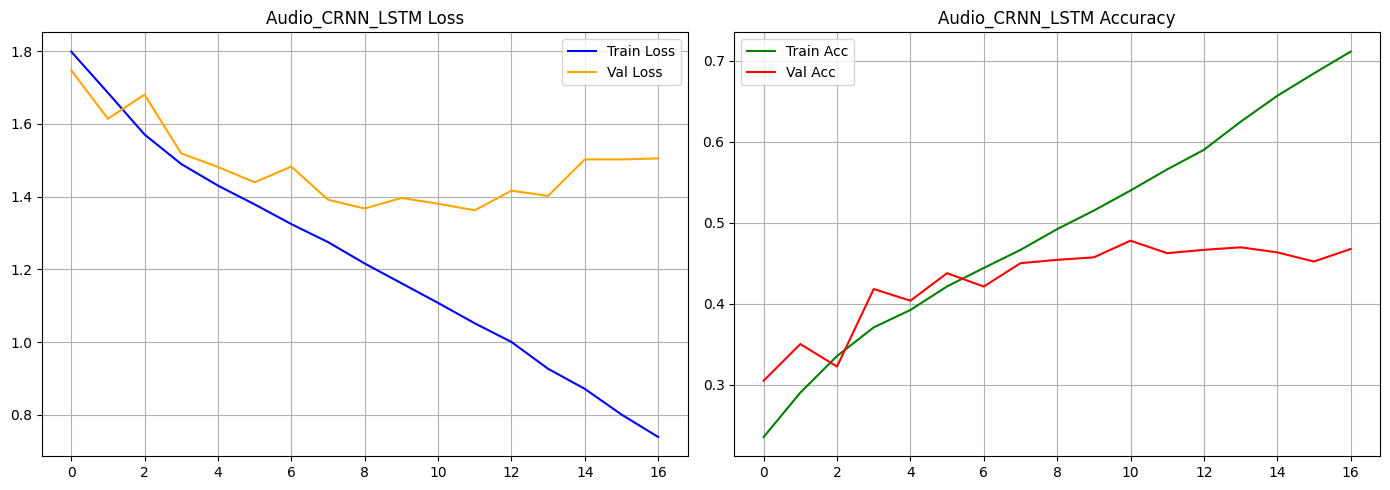

64/64 ━━━━━━━━━━━━━━━━━━━━ 24s 377ms/step


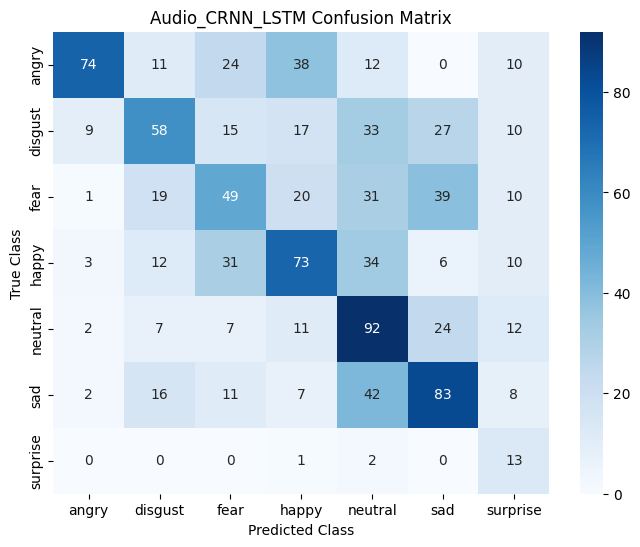

              precision    recall  f1-score   support

       angry       0.81      0.44      0.57       169
     disgust       0.47      0.34      0.40       169
        fear       0.36      0.29      0.32       169
       happy       0.44      0.43      0.43       169
     neutral       0.37      0.59      0.46       155
         sad       0.46      0.49      0.48       169
    surprise       0.18      0.81      0.29        16

    accuracy                           0.44      1016
   macro avg       0.44      0.49      0.42      1016
weighted avg       0.48      0.44      0.44      1016



In [ ]:
tf.keras.backend.clear_session(); gc.collect()
NAME = "Audio_CRNN_LSTM"
print(f"Training {NAME}...")

train_gen = NpyDataGenerator(train_aud, eff_preprocess, batch_size=16)
val_gen = NpyDataGenerator(val_aud, eff_preprocess, batch_size=16, shuffle=False)
test_gen = NpyDataGenerator(test_aud, eff_preprocess, batch_size=16, shuffle=False)

model = get_audio_cnn_lstm(AUDIO_IMG_SIZE+(3,), NUM_CLASSES)
model.compile(optimizer=Adam(1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

callbacks = [EarlyStopping(patience=5, restore_best_weights=True), ModelCheckpoint(f"models_zoo_1/{NAME}.keras", save_best_only=True, monitor='val_accuracy')]

print("Starting Training...")
start_train = time.time()

hist = model.fit(train_gen, validation_data=val_gen, epochs=20, callbacks=callbacks, class_weight=class_weights_dict, verbose=1)

end_train = time.time()  
total_train_minutes = (end_train - start_train) / 60

print(f"Total Training Time: {total_train_minutes:.2f} minutes")

model.load_weights(f"models_zoo_1/{NAME}.keras")
visualize_training(hist, model, test_gen, NAME)

Face Model

CNN

Training Face_Baseline_CNN...
Using column 'label' for labels.
Found 7962 validated image filenames belonging to 7 classes.
Found 971 validated image filenames belonging to 7 classes.
Found 1016 validated image filenames belonging to 7 classes.
Starting Training...
Epoch 1/15
498/498 ━━━━━━━━━━━━━━━━━━━━ 257s 514ms/step - accuracy: 0.1213 - loss: 4.3377 - val_accuracy: 0.0330 - val_loss: 1.9461
Epoch 2/15
498/498 ━━━━━━━━━━━━━━━━━━━━ 209s 420ms/step - accuracy: 0.0551 - loss: 1.9618 - val_accuracy: 0.0330 - val_loss: 1.9465
Epoch 3/15
498/498 ━━━━━━━━━━━━━━━━━━━━ 203s 408ms/step - accuracy: 0.0362 - loss: 1.9618 - val_accuracy: 0.0330 - val_loss: 1.9469
Epoch 4/15
498/498 ━━━━━━━━━━━━━━━━━━━━ 202s 406ms/step - accuracy: 0.0362 - loss: 1.9618 - val_accuracy: 0.0330 - val_loss: 1.9472
Epoch 5/15
498/498 ━━━━━━━━━━━━━━━━━━━━ 206s 413ms/step - accuracy: 0.0362 - loss: 1.9617 - val_accuracy: 0.0330 - val_loss: 1.9475
Epoch 6/15
498/498 ━━━━━━━━━━━━━━━━━━━━ 212s 425ms/step - accuracy: 0.0362

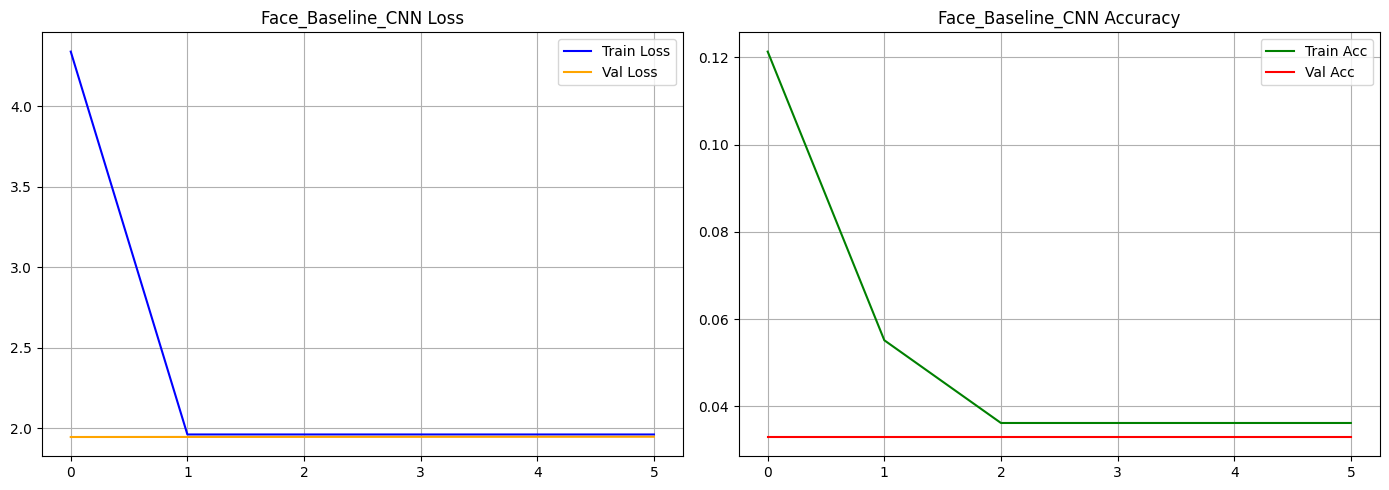

64/64 ━━━━━━━━━━━━━━━━━━━━ 8s 129ms/step


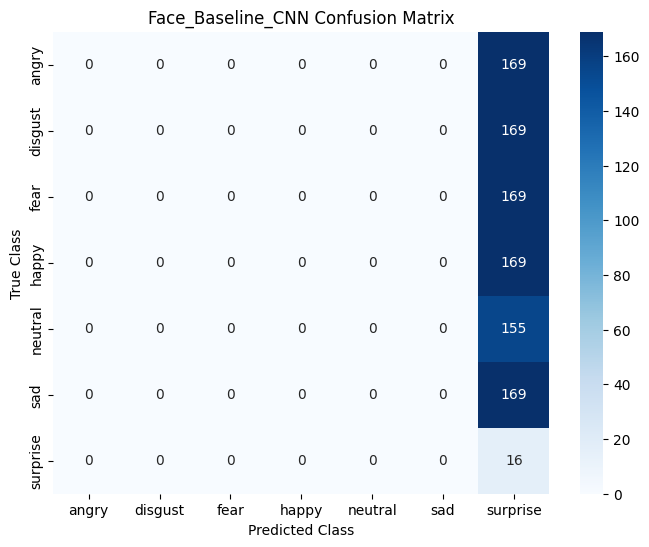

              precision    recall  f1-score   support

       angry       0.00      0.00      0.00       169
     disgust       0.00      0.00      0.00       169
        fear       0.00      0.00      0.00       169
       happy       0.00      0.00      0.00       169
     neutral       0.00      0.00      0.00       155
         sad       0.00      0.00      0.00       169
    surprise       0.02      1.00      0.03        16

    accuracy                           0.02      1016
   macro avg       0.00      0.14      0.00      1016
weighted avg       0.00      0.02      0.00      1016



In [ ]:
tf.keras.backend.clear_session()
import gc
gc.collect()

NAME = "Face_Baseline_CNN"
print(f"Training {NAME}...")

label_column = 'label'
if 'label_str' in train_df.columns:
    label_column = 'label_str'

print(f"Using column '{label_column}' for labels.")

train_datagen = ImageDataGenerator(
    preprocessing_function=eff_preprocess,
    rotation_range=20, width_shift_range=0.2, height_shift_range=0.2, 
    zoom_range=0.2, horizontal_flip=True, fill_mode='nearest'
)
test_datagen = ImageDataGenerator(preprocessing_function=eff_preprocess)

train_g = train_datagen.flow_from_dataframe(train_df, x_col='face_path', y_col=label_column, target_size=(224,224), batch_size=16, class_mode='categorical')
val_g = test_datagen.flow_from_dataframe(val_df, x_col='face_path', y_col=label_column, target_size=(224,224), batch_size=16, class_mode='categorical', shuffle=False)
test_g = test_datagen.flow_from_dataframe(test_df, x_col='face_path', y_col=label_column, target_size=(224,224), batch_size=16, class_mode='categorical', shuffle=False)

model = get_simple_baseline((224,224,3), NUM_CLASSES, NAME)
model.compile(optimizer=Adam(1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

callbacks = [EarlyStopping(patience=5, restore_best_weights=True), ModelCheckpoint(f"models_zoo_1/{NAME}.keras", save_best_only=True, monitor='val_accuracy')]

print("Starting Training...")
start_train = time.time()

hist = model.fit(train_g, validation_data=val_g, epochs=15, callbacks=callbacks, class_weight=class_weights_dict, verbose=1)

end_train = time.time()    
total_train_minutes = (end_train - start_train) / 60

print(f"Total Training Time: {total_train_minutes:.2f} minutes")

model.load_weights(f"models_zoo_1/{NAME}.keras")
visualize_training(hist, model, test_g, NAME)

Xception

Training Face_Xception...
Found 7962 validated image filenames belonging to 7 classes.
Found 971 validated image filenames belonging to 7 classes.
Found 1016 validated image filenames belonging to 7 classes.
Starting Training...
Epoch 1/15
498/498 ━━━━━━━━━━━━━━━━━━━━ 1010s 2s/step - accuracy: 0.2278 - loss: 3.0869 - val_accuracy: 0.3296 - val_loss: 2.4605
Epoch 2/15
498/498 ━━━━━━━━━━━━━━━━━━━━ 1040s 2s/step - accuracy: 0.2709 - loss: 2.8050 - val_accuracy: 0.3594 - val_loss: 2.3780
Epoch 3/15
498/498 ━━━━━━━━━━━━━━━━━━━━ 1012s 2s/step - accuracy: 0.2952 - loss: 2.6657 - val_accuracy: 0.3543 - val_loss: 2.3642
Epoch 4/15
498/498 ━━━━━━━━━━━━━━━━━━━━ 1009s 2s/step - accuracy: 0.3260 - loss: 2.5297 - val_accuracy: 0.4058 - val_loss: 2.2755
Epoch 5/15
498/498 ━━━━━━━━━━━━━━━━━━━━ 993s 2s/step - accuracy: 0.3336 - loss: 2.4677 - val_accuracy: 0.3780 - val_loss: 2.3102
Epoch 6/15
498/498 ━━━━━━━━━━━━━━━━━━━━ 1014s 2s/step - accuracy: 0.3362 - loss: 2.4112 - val_accuracy: 0.4006 - val_loss:

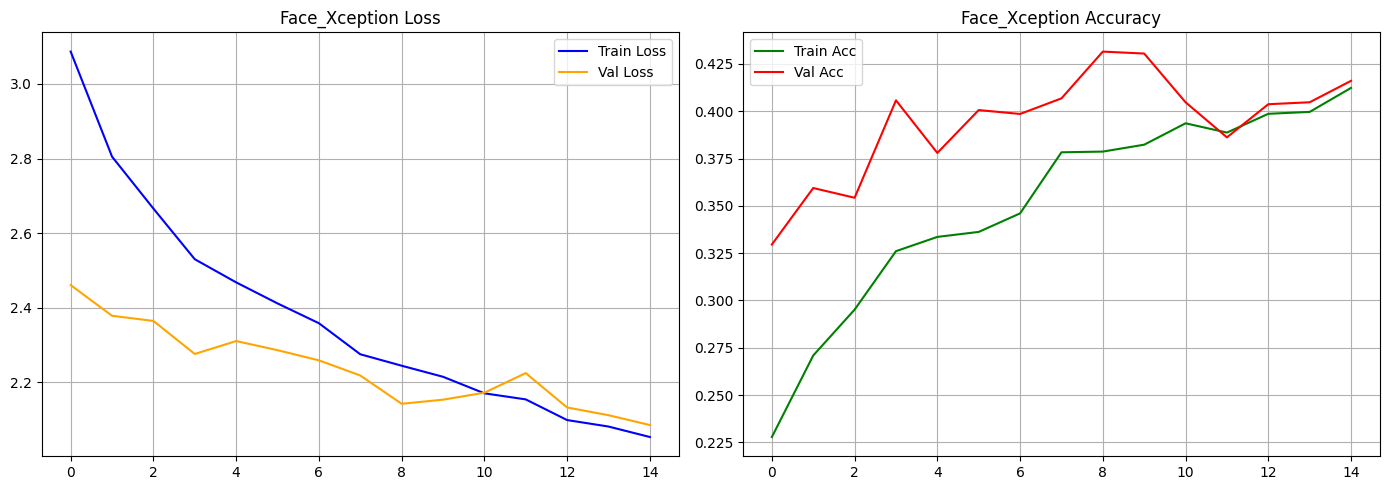

64/64 ━━━━━━━━━━━━━━━━━━━━ 115s 2s/step


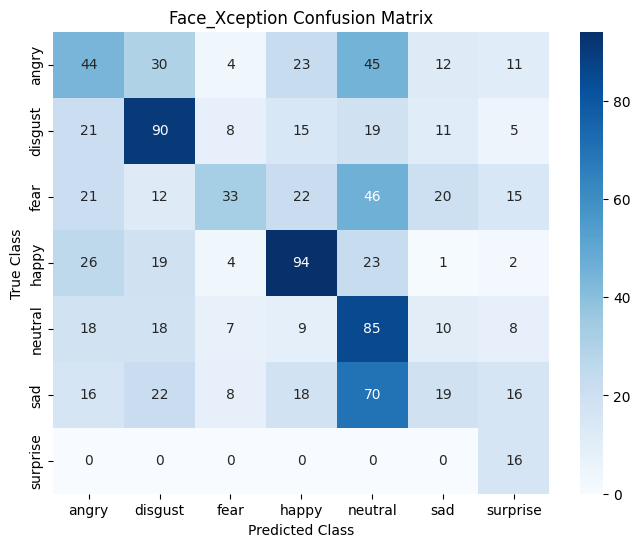

              precision    recall  f1-score   support

       angry       0.30      0.26      0.28       169
     disgust       0.47      0.53      0.50       169
        fear       0.52      0.20      0.28       169
       happy       0.52      0.56      0.54       169
     neutral       0.30      0.55      0.38       155
         sad       0.26      0.11      0.16       169
    surprise       0.22      1.00      0.36        16

    accuracy                           0.38      1016
   macro avg       0.37      0.46      0.36      1016
weighted avg       0.39      0.38      0.36      1016



In [ ]:
tf.keras.backend.clear_session()
import gc
gc.collect()

NAME = "Face_Xception"
print(f"Training {NAME}...")

label_column = 'label'
if 'label_str' in train_df.columns:
    label_column = 'label_str'

train_datagen = ImageDataGenerator(
    preprocessing_function=xcp_preprocess,
    rotation_range=20, width_shift_range=0.2, height_shift_range=0.2, 
    zoom_range=0.2, horizontal_flip=True, fill_mode='nearest'
)
test_datagen = ImageDataGenerator(preprocessing_function=xcp_preprocess)

train_g = train_datagen.flow_from_dataframe(train_df, x_col='face_path', y_col=label_column, target_size=(299,299), batch_size=16, class_mode='categorical')
val_g = test_datagen.flow_from_dataframe(val_df, x_col='face_path', y_col=label_column, target_size=(299,299), batch_size=16, class_mode='categorical', shuffle=False)
test_g = test_datagen.flow_from_dataframe(test_df, x_col='face_path', y_col=label_column, target_size=(299,299), batch_size=16, class_mode='categorical', shuffle=False)

model = get_face_transfer_model(Xception, (299,299,3), NUM_CLASSES, NAME)
model.compile(optimizer=Adam(1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

callbacks = [EarlyStopping(patience=5, restore_best_weights=True), ModelCheckpoint(f"models_zoo_1/{NAME}.keras", save_best_only=True, monitor='val_accuracy')]

print("Starting Training...")
start_train = time.time()

hist = model.fit(
    train_g, 
    validation_data=val_g, 
    epochs=15, 
    callbacks=callbacks, 
    class_weight=class_weights_dict, 
    verbose=1
)
end_train = time.time()    
total_train_minutes = (end_train - start_train) / 60

print(f"Total Training Time: {total_train_minutes:.2f} minutes")

model.load_weights(f"models_zoo_1/{NAME}.keras")
visualize_training(hist, model, test_g, NAME)

ResNet50

Training Face_ResNet50...
Found 7962 validated image filenames belonging to 7 classes.
Found 971 validated image filenames belonging to 7 classes.
Found 1016 validated image filenames belonging to 7 classes.
Starting Training...
Epoch 1/15
498/498 ━━━━━━━━━━━━━━━━━━━━ 455s 906ms/step - accuracy: 0.2337 - loss: 3.1907 - val_accuracy: 0.3275 - val_loss: 2.4623
Epoch 2/15
498/498 ━━━━━━━━━━━━━━━━━━━━ 443s 889ms/step - accuracy: 0.2865 - loss: 2.8485 - val_accuracy: 0.3759 - val_loss: 2.4540
Epoch 3/15
498/498 ━━━━━━━━━━━━━━━━━━━━ 442s 888ms/step - accuracy: 0.3222 - loss: 2.6476 - val_accuracy: 0.4037 - val_loss: 2.3599
Epoch 4/15
498/498 ━━━━━━━━━━━━━━━━━━━━ 436s 875ms/step - accuracy: 0.3384 - loss: 2.5440 - val_accuracy: 0.4150 - val_loss: 2.3181
Epoch 5/15
498/498 ━━━━━━━━━━━━━━━━━━━━ 440s 884ms/step - accuracy: 0.3671 - loss: 2.4301 - val_accuracy: 0.3872 - val_loss: 2.3673
Epoch 6/15
498/498 ━━━━━━━━━━━━━━━━━━━━ 437s 878ms/step - accuracy: 0.3745 - loss: 2.3563 - val_accuracy: 0.447

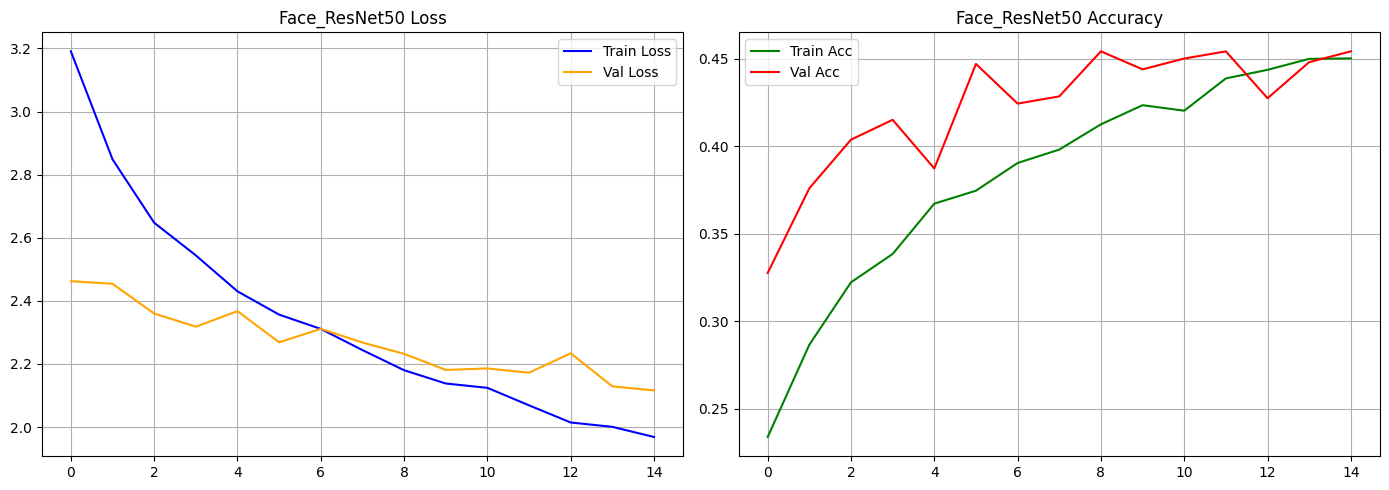

64/64 ━━━━━━━━━━━━━━━━━━━━ 52s 789ms/step


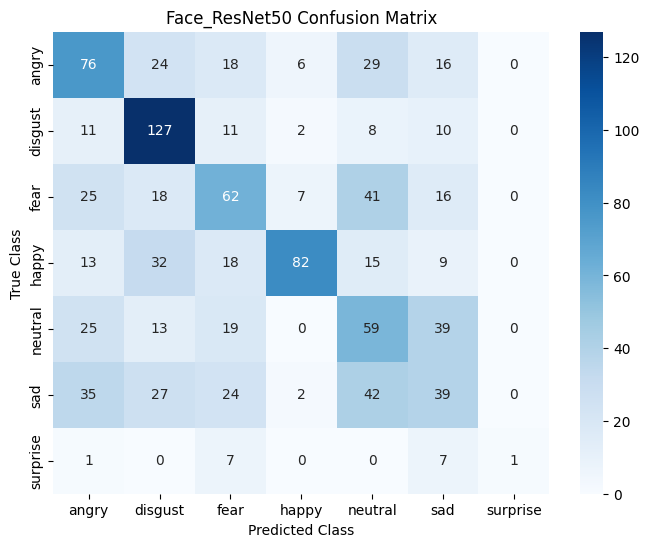

              precision    recall  f1-score   support

       angry       0.41      0.45      0.43       169
     disgust       0.53      0.75      0.62       169
        fear       0.39      0.37      0.38       169
       happy       0.83      0.49      0.61       169
     neutral       0.30      0.38      0.34       155
         sad       0.29      0.23      0.26       169
    surprise       1.00      0.06      0.12        16

    accuracy                           0.44      1016
   macro avg       0.53      0.39      0.39      1016
weighted avg       0.47      0.44      0.43      1016



In [ ]:
tf.keras.backend.clear_session()
gc.collect()

NAME = "Face_ResNet50"
print(f"Training {NAME}...")

label_column = 'label'
if 'label_str' in train_df.columns:
    label_column = 'label_str'

train_datagen = ImageDataGenerator(
    preprocessing_function=res_preprocess,
    rotation_range=20, width_shift_range=0.2, height_shift_range=0.2, 
    zoom_range=0.2, horizontal_flip=True, fill_mode='nearest'
)
test_datagen = ImageDataGenerator(preprocessing_function=res_preprocess)

train_g = train_datagen.flow_from_dataframe(train_df, x_col='face_path', y_col=label_column, target_size=(224,224), batch_size=16, class_mode='categorical')
val_g = test_datagen.flow_from_dataframe(val_df, x_col='face_path', y_col=label_column, target_size=(224,224), batch_size=16, class_mode='categorical', shuffle=False)
test_g = test_datagen.flow_from_dataframe(test_df, x_col='face_path', y_col=label_column, target_size=(224,224), batch_size=16, class_mode='categorical', shuffle=False)

model = get_face_transfer_model(ResNet50, (224,224,3), NUM_CLASSES, NAME)
model.compile(optimizer=Adam(1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

callbacks = [EarlyStopping(patience=5, restore_best_weights=True), ModelCheckpoint(f"models_zoo_1/{NAME}.keras", save_best_only=True, monitor='val_accuracy')]

print("Starting Training...")
start_train = time.time()

hist = model.fit(
    train_g, 
    validation_data=val_g, 
    epochs=15, 
    callbacks=callbacks, 
    class_weight=class_weights_dict, 
    verbose=1
)

end_train = time.time()   
total_train_minutes = (end_train - start_train) / 60

print(f"Total Training Time: {total_train_minutes:.2f} minutes")

model.load_weights(f"models_zoo_1/{NAME}.keras")
visualize_training(hist, model, test_g, NAME)

EfficientNet Baseline

In [58]:
def get_face_transfer_model(base_arch, input_shape, num_classes, name):
    base = base_arch(weights='imagenet', include_top=False, input_shape=input_shape)
    base.trainable = True
    for layer in base.layers[:int(len(base.layers)*0.8)]: layer.trainable = False
    x = GlobalAveragePooling2D()(base.output); x = Dense(256, activation='relu')(x); x = Dropout(0.5)(x)
    out = Dense(num_classes, activation='softmax')(x)
    return Model(base.input, out, name=name)

Training Face_EfficientNetB0...
Found 7962 validated image filenames belonging to 7 classes.
Found 971 validated image filenames belonging to 7 classes.
Found 1016 validated image filenames belonging to 7 classes.
Epoch 1/15
498/498 ━━━━━━━━━━━━━━━━━━━━ 217s 416ms/step - accuracy: 0.2968 - loss: 1.6619 - val_accuracy: 0.3872 - val_loss: 1.5053
Epoch 2/15
498/498 ━━━━━━━━━━━━━━━━━━━━ 208s 418ms/step - accuracy: 0.4598 - loss: 1.3153 - val_accuracy: 0.4696 - val_loss: 1.3494
Epoch 3/15
498/498 ━━━━━━━━━━━━━━━━━━━━ 211s 424ms/step - accuracy: 0.5317 - loss: 1.1501 - val_accuracy: 0.5314 - val_loss: 1.3116
Epoch 4/15
498/498 ━━━━━━━━━━━━━━━━━━━━ 220s 442ms/step - accuracy: 0.5590 - loss: 1.0848 - val_accuracy: 0.5582 - val_loss: 1.2720
Epoch 5/15
498/498 ━━━━━━━━━━━━━━━━━━━━ 205s 412ms/step - accuracy: 0.5933 - loss: 1.0036 - val_accuracy: 0.5242 - val_loss: 1.4211
Epoch 6/15
498/498 ━━━━━━━━━━━━━━━━━━━━ 210s 421ms/step - accuracy: 0.6066 - loss: 0.9531 - val_accuracy: 0.5561 - val_loss: 1

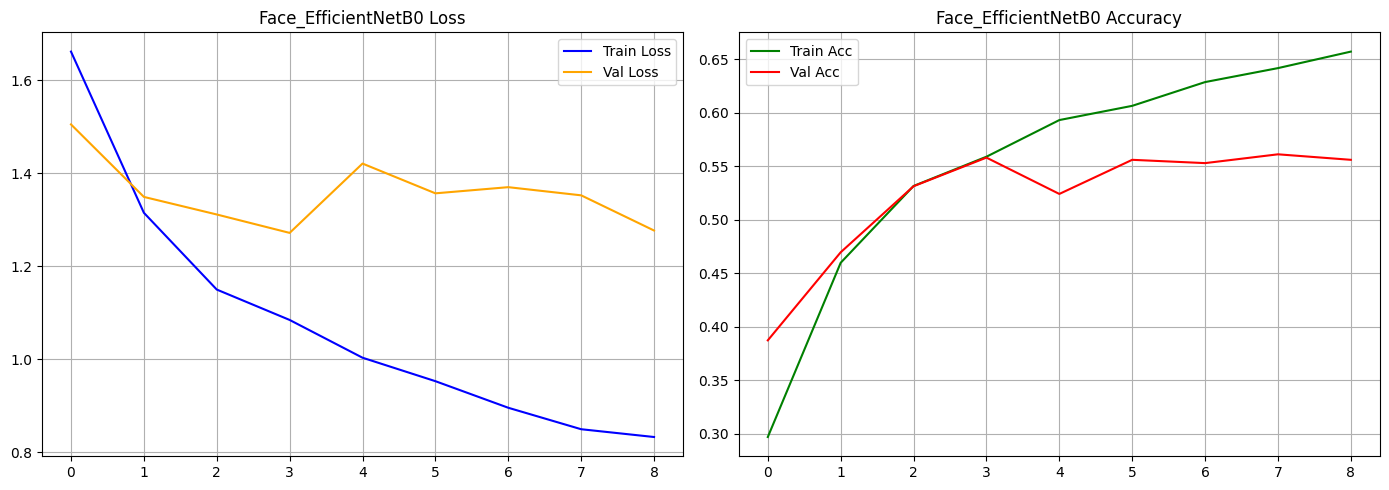

64/64 ━━━━━━━━━━━━━━━━━━━━ 19s 275ms/step


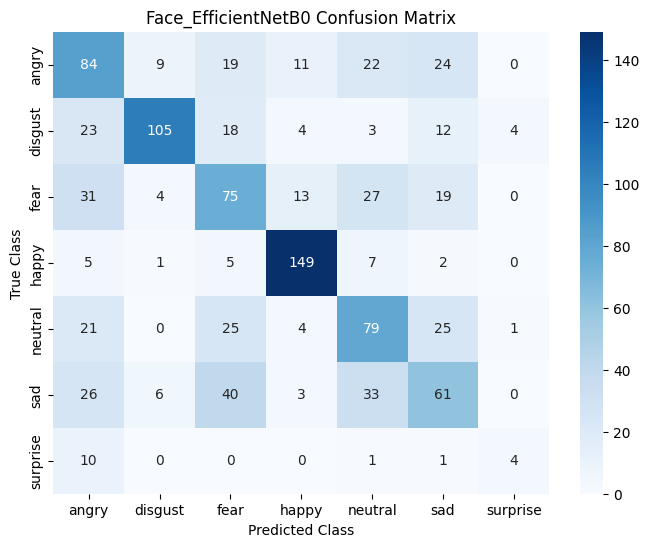

              precision    recall  f1-score   support

       angry       0.42      0.50      0.46       169
     disgust       0.84      0.62      0.71       169
        fear       0.41      0.44      0.43       169
       happy       0.81      0.88      0.84       169
     neutral       0.46      0.51      0.48       155
         sad       0.42      0.36      0.39       169
    surprise       0.44      0.25      0.32        16

    accuracy                           0.55      1016
   macro avg       0.54      0.51      0.52      1016
weighted avg       0.56      0.55      0.55      1016



In [ ]:
tf.keras.backend.clear_session()
gc.collect()

from tensorflow.keras.applications import EfficientNetB0
NAME = "Face_EfficientNetB0"
print(f"Training {NAME}...")

label_column = 'label'
if 'label_str' in train_df.columns:
    label_column = 'label_str'

train_datagen = ImageDataGenerator(
    preprocessing_function=eff_preprocess,
    rotation_range=20, width_shift_range=0.2, height_shift_range=0.2, 
    zoom_range=0.2, horizontal_flip=True, fill_mode='nearest'
)
test_datagen = ImageDataGenerator(preprocessing_function=eff_preprocess)

train_g = train_datagen.flow_from_dataframe(train_df, x_col='face_path', y_col=label_column, target_size=(224,224), batch_size=16, class_mode='categorical')
val_g = test_datagen.flow_from_dataframe(val_df, x_col='face_path', y_col=label_column, target_size=(224,224), batch_size=16, class_mode='categorical', shuffle=False)
test_g = test_datagen.flow_from_dataframe(test_df, x_col='face_path', y_col=label_column, target_size=(224,224), batch_size=16, class_mode='categorical', shuffle=False)

model = get_face_transfer_model(EfficientNetB0, (224,224,3), NUM_CLASSES, NAME)
model.compile(optimizer=Adam(1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

callbacks = [EarlyStopping(patience=5, restore_best_weights=True), ModelCheckpoint(f"models_zoo_1/{NAME}.keras", save_best_only=True, monitor='val_accuracy')]

hist = model.fit(
    train_g, 
    validation_data=val_g, 
    epochs=15, 
    callbacks=callbacks, 
    class_weight=class_weights_dict, 
    verbose=1
)

end_train = time.time()    
total_train_minutes = (end_train - start_train) / 60

print(f"Total Training Time: {total_train_minutes:.2f} minutes")

model.load_weights(f"models_zoo_1/{NAME}.keras")
visualize_training(hist, model, test_g, NAME)

Model Comparison

In [ ]:
import os
import shutil
import tensorflow as tf
from tensorflow.keras.models import load_model

MODEL_DIR = "models_zoo_1"
BATCH_SIZE = 16

AUDIO_CANDIDATES = ["Audio_Baseline_CNN", "Audio_EfficientNet", "Audio_ResNet50", "Audio_CRNN_LSTM", "Audio_EfficientNet_Augmented"]
FACE_CANDIDATES = ["Face_Baseline_CNN", "Face_Xception", "Face_ResNet50", "Face_EfficientNetB0","Face_EfficientNetB0_1_1", "Face_EfficientNet"]

label_column = 'label'
if 'label_str' in test_df.columns:
    label_column = 'label_str'

# --- 1. DEFINE SCALING WRAPPER HERE TOO ---
def audio_preprocess_wrapper(img):
    img = img * 255.0
    return eff_preprocess(img)

def get_preprocess_func(model_name, modality):
    if "ResNet" in model_name: return res_preprocess
    if "Xception" in model_name: return xcp_preprocess
    
    if modality == "AUDIO" and "EfficientNet" in model_name:
        return audio_preprocess_wrapper
        
    return eff_preprocess

def evaluate_candidate(name, modality, test_df_data):
    path = os.path.join(MODEL_DIR, f"{name}.keras")
    if not os.path.exists(path):
        print(f"   Skipping {name} (File not found)")
        return -1.0

    print(f"   Testing {name}...", end="")
    try:
        model = load_model(path, compile=True)
        pre_func = get_preprocess_func(name, modality) 
        
        input_shape = model.input_shape[1:]
        target_size = (input_shape[0], input_shape[1])
        
        if modality == "AUDIO":
            gen = NpyDataGenerator(test_df_data, pre_func, BATCH_SIZE, target_size=target_size, shuffle=False)
        else:
            datagen = ImageDataGenerator(preprocessing_function=pre_func)
            gen = datagen.flow_from_dataframe(
                test_df_data, x_col='face_path', y_col=label_column,
                target_size=target_size, batch_size=BATCH_SIZE, class_mode='categorical', shuffle=False
            )
            
        loss, acc = model.evaluate(gen, verbose=0)
        print(f" Score: {acc*100:.2f}%")
        del model
        tf.keras.backend.clear_session()
        return acc
    except Exception as e:
        print(f" Error: {e}")
        return -1.0

print("\n--- EVALUATING AUDIO MODELS ---")
best_audio_name = None; best_audio_score = -1.0
for name in AUDIO_CANDIDATES:
    score = evaluate_candidate(name, "AUDIO", test_aud)
    if score > best_audio_score:
        best_audio_score = score; best_audio_name = name

print("\n--- EVALUATING FACE MODELS ---")
best_face_name = None; best_face_score = -1.0
for name in FACE_CANDIDATES:
    score = evaluate_candidate(name, "FACE", test_df)
    if score > best_face_score:
        best_face_score = score; best_face_name = name

print("\n" + "="*40 + "\nFINAL RESULTS\n" + "="*40)
if best_audio_name:
    print(f"Best Audio: {best_audio_name} ({best_audio_score*100:.2f}%)")
    shutil.copy(os.path.join(MODEL_DIR, f"{best_audio_name}.keras"), os.path.join(MODEL_DIR, "best_audio.keras"))
else: print("No valid Audio models found.")

if best_face_name:
    print(f"Best Face:  {best_face_name} ({best_face_score*100:.2f}%)")
    shutil.copy(os.path.join(MODEL_DIR, f"{best_face_name}.keras"), os.path.join(MODEL_DIR, "best_face.keras"))
else: print("No valid Face models found.")


--- EVALUATING AUDIO MODELS ---
   Testing Audio_Baseline_CNN...

c:\Users\User\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


 Score: 40.55%
   Testing Audio_EfficientNet...

c:\Users\User\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


 Score: 52.36%
   Testing Audio_ResNet50...

c:\Users\User\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


 Score: 40.55%
   Testing Audio_CRNN_LSTM...

c:\Users\User\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


 Score: 43.50%
   Testing Audio_EfficientNet_Augmented...

c:\Users\User\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


 Score: 45.87%

--- EVALUATING FACE MODELS ---
   Testing Face_Baseline_CNN...Found 1016 validated image filenames belonging to 7 classes.
 Score: 1.57%
   Testing Face_Xception...Found 1016 validated image filenames belonging to 7 classes.
 Score: 37.50%
   Testing Face_ResNet50...Found 1016 validated image filenames belonging to 7 classes.
 Score: 43.90%
   Testing Face_EfficientNetB0...Found 1016 validated image filenames belonging to 7 classes.
 Score: 54.82%
   Testing Face_EfficientNetB0_1_1...Found 1016 validated image filenames belonging to 7 classes.
 Score: 44.78%
   Testing Face_EfficientNet...Found 1016 validated image filenames belonging to 7 classes.
 Score: 54.72%

FINAL RESULTS
Best Audio: Audio_EfficientNet (52.36%)
Best Face:  Face_EfficientNetB0 (54.82%)


EfficientNet (To reduce overfit)

In [ ]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

y_train_indices = le.transform(train_df['label_str'])

class_weights = compute_class_weight(
    class_weight='balanced', 
    classes=np.unique(y_train_indices), 
    y=y_train_indices
)

class_weights_dict = dict(enumerate(class_weights))

print("FRESH Class Weights:", class_weights_dict)

FRESH Class Weights: {0: np.float64(0.8893108455266391), 1: np.float64(0.8893108455266391), 2: np.float64(0.8886160714285715), 3: np.float64(0.8907036581273073), 4: np.float64(0.8886160714285715), 5: np.float64(0.8893108455266391), 6: np.float64(3.949404761904762)}


In [34]:
import os
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'
import tensorflow as tf

In [35]:
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

Training Face_EfficientNet...
Found 7962 validated image filenames belonging to 7 classes.
Found 971 validated image filenames belonging to 7 classes.
Found 1016 validated image filenames belonging to 7 classes.
Epoch 1/10
498/498 ━━━━━━━━━━━━━━━━━━━━ 1046s 2s/step - accuracy: 0.2931 - loss: 2.0972 - val_accuracy: 0.4706 - val_loss: 1.7487 - learning_rate: 1.0000e-04
Epoch 2/10
498/498 ━━━━━━━━━━━━━━━━━━━━ 956s 2s/step - accuracy: 0.4800 - loss: 1.6684 - val_accuracy: 0.5705 - val_loss: 1.5174 - learning_rate: 1.0000e-04
Epoch 3/10
498/498 ━━━━━━━━━━━━━━━━━━━━ 953s 2s/step - accuracy: 0.5835 - loss: 1.4233 - val_accuracy: 0.5922 - val_loss: 1.4870 - learning_rate: 1.0000e-04
Epoch 4/10
498/498 ━━━━━━━━━━━━━━━━━━━━ 954s 2s/step - accuracy: 0.6285 - loss: 1.2938 - val_accuracy: 0.6179 - val_loss: 1.3924 - learning_rate: 1.0000e-04
Epoch 5/10
498/498 ━━━━━━━━━━━━━━━━━━━━ 1123s 2s/step - accuracy: 0.6722 - loss: 1.1701 - val_accuracy: 0.6395 - val_loss: 1.3881 - learning_rate: 1.0000e-04
E

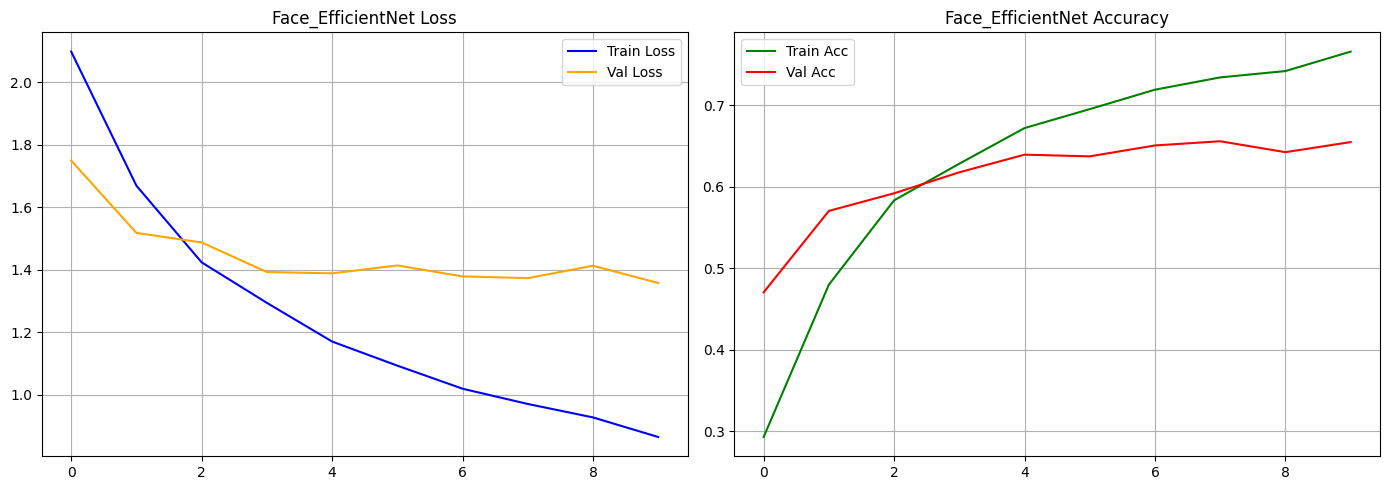

64/64 ━━━━━━━━━━━━━━━━━━━━ 28s 414ms/step


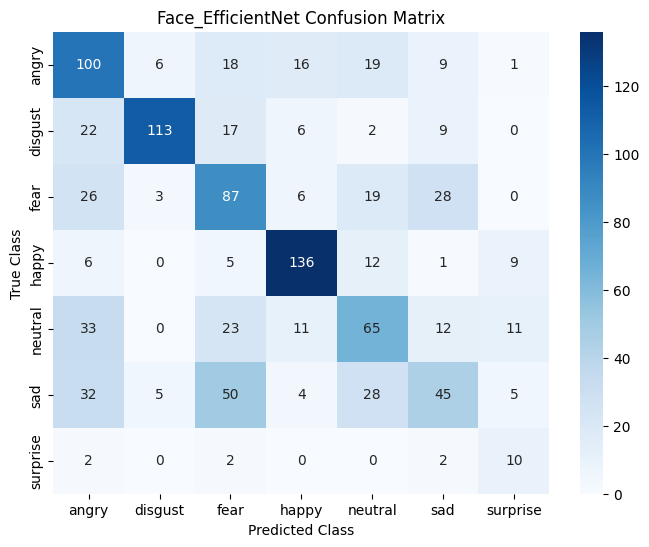

              precision    recall  f1-score   support

       angry       0.45      0.59      0.51       169
     disgust       0.89      0.67      0.76       169
        fear       0.43      0.51      0.47       169
       happy       0.76      0.80      0.78       169
     neutral       0.45      0.42      0.43       155
         sad       0.42      0.27      0.33       169
    surprise       0.28      0.62      0.38        16

    accuracy                           0.55      1016
   macro avg       0.53      0.56      0.52      1016
weighted avg       0.56      0.55      0.55      1016



In [ ]:
import tensorflow as tf
import time
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras import layers, regularizers
from tensorflow.keras.callbacks import ReduceLROnPlateau
import gc

tf.keras.backend.clear_session()
gc.collect()

NAME = "Face_EfficientNet"
print(f"Training {NAME}...")

label_column = 'label'
if 'label_str' in train_df.columns:
    label_column = 'label_str'

train_datagen = ImageDataGenerator(
    preprocessing_function=eff_preprocess,
    rotation_range=15,       # Reduced from 20
    width_shift_range=0.15,  # Reduced from 0.2
    height_shift_range=0.15, # Reduced from 0.2
    zoom_range=0.15,         # Reduced from 0.2
    horizontal_flip=True, 
    fill_mode='nearest'
)
test_datagen = ImageDataGenerator(preprocessing_function=eff_preprocess)

train_g = train_datagen.flow_from_dataframe(train_df, x_col='face_path', y_col=label_column, target_size=(224,224), batch_size=16, class_mode='categorical')
val_g = test_datagen.flow_from_dataframe(val_df, x_col='face_path', y_col=label_column, target_size=(224,224), batch_size=16, class_mode='categorical', shuffle=False)
test_g = test_datagen.flow_from_dataframe(test_df, x_col='face_path', y_col=label_column, target_size=(224,224), batch_size=16, class_mode='categorical', shuffle=False)

# + Regularization
def get_stabilized_face_model(base_model_class, input_shape, num_classes, name):
    base_model = base_model_class(include_top=False, weights='imagenet', input_shape=input_shape)
    base_model.trainable = True # Fine-tuning
    
    inputs = tf.keras.Input(shape=input_shape)
    x = base_model(inputs)
    x = layers.GlobalAveragePooling2D()(x)

    x = layers.Dropout(0.5)(x) # High dropout
    x = layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001))(x) # L2 Reg
    x = layers.Dropout(0.4)(x)
    
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    return tf.keras.Model(inputs, outputs, name=name)

model = get_stabilized_face_model(EfficientNetB0, (224,224,3), NUM_CLASSES, NAME)

# lower starting LR
model.compile(optimizer=Adam(1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

# (Added ReduceLROnPlateau)
callbacks = [
    # Reduce LR if val_loss stagnates for 2 epochs (Critical for stability)
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-6, verbose=1),  
    # Early Stopping
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1),
    # Save Best
    ModelCheckpoint(f"models_zoo_1/{NAME}.keras", save_best_only=True, monitor='val_accuracy')
]

# 5. Train
start_train = time.time()
hist = model.fit(
    train_g, 
    validation_data=val_g, 
    epochs=10, # Increased slightly to let LR scheduler work
    callbacks=callbacks, 
    class_weight=class_weights_dict, 
    verbose=1
)

end_train = time.time()
total_train_minutes = (end_train - start_train) / 60
print(f"Total Training Time: {total_train_minutes:.2f} minutes")

model.load_weights(f"models_zoo_1/{NAME}.keras")
visualize_training(hist, model, test_g, NAME)

Training efficientnet_improved...
Found 7962 validated image filenames belonging to 7 classes.
Found 971 validated image filenames belonging to 7 classes.
Found 1016 validated image filenames belonging to 7 classes.
Epoch 1/15
498/498 ━━━━━━━━━━━━━━━━━━━━ 1003s 2s/step - accuracy: 0.1939 - loss: 2.6130 - val_accuracy: 0.2956 - val_loss: 2.1002 - learning_rate: 5.0000e-05
Epoch 2/15
498/498 ━━━━━━━━━━━━━━━━━━━━ 1176s 2s/step - accuracy: 0.2764 - loss: 2.2990 - val_accuracy: 0.3934 - val_loss: 1.8664 - learning_rate: 5.0000e-05
Epoch 3/15
498/498 ━━━━━━━━━━━━━━━━━━━━ 956s 2s/step - accuracy: 0.3287 - loss: 2.1184 - val_accuracy: 0.4387 - val_loss: 1.7285 - learning_rate: 5.0000e-05
Epoch 4/15
498/498 ━━━━━━━━━━━━━━━━━━━━ 1083s 2s/step - accuracy: 0.3742 - loss: 1.9513 - val_accuracy: 0.4686 - val_loss: 1.6816 - learning_rate: 5.0000e-05
Epoch 5/15
498/498 ━━━━━━━━━━━━━━━━━━━━ 1003s 2s/step - accuracy: 0.4005 - loss: 1.8685 - val_accuracy: 0.5304 - val_loss: 1.5801 - learning_rate: 5.0000

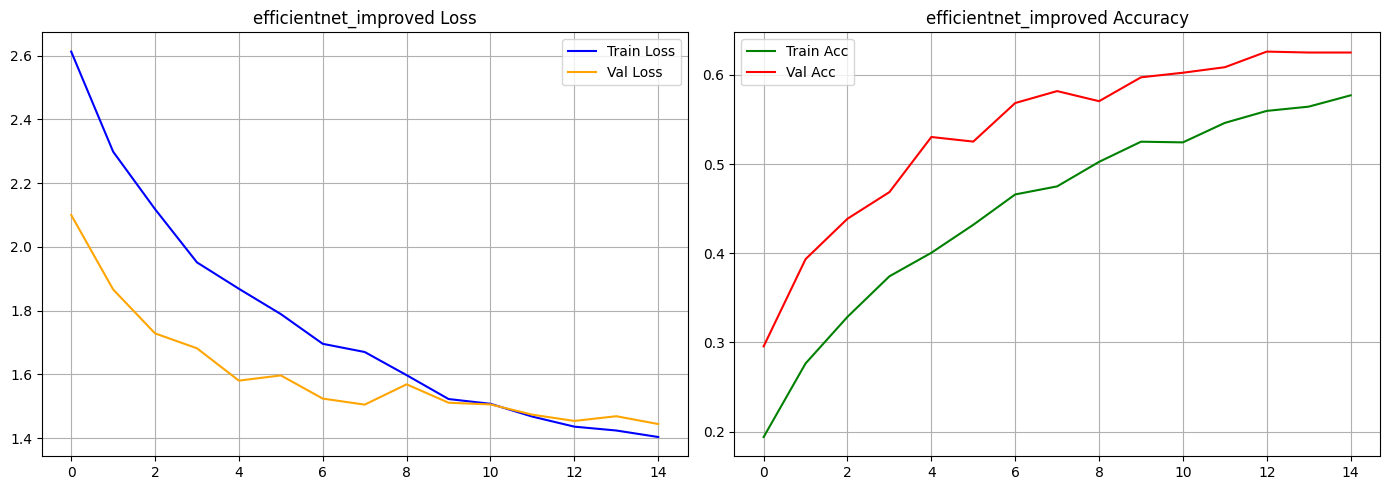

64/64 ━━━━━━━━━━━━━━━━━━━━ 34s 499ms/step


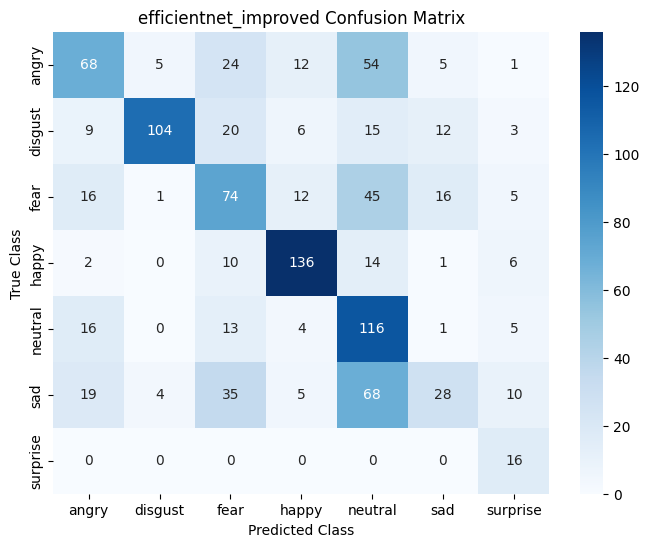

              precision    recall  f1-score   support

       angry       0.52      0.40      0.45       169
     disgust       0.91      0.62      0.73       169
        fear       0.42      0.44      0.43       169
       happy       0.78      0.80      0.79       169
     neutral       0.37      0.75      0.50       155
         sad       0.44      0.17      0.24       169
    surprise       0.35      1.00      0.52        16

    accuracy                           0.53      1016
   macro avg       0.54      0.60      0.52      1016
weighted avg       0.57      0.53      0.52      1016



In [ ]:
import tensorflow as tf
import time
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras import layers, regularizers, optimizers
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
import gc

tf.keras.backend.clear_session()
gc.collect()

NAME = "efficientnet_improved" 
print(f"Training {NAME}...")

train_datagen = ImageDataGenerator(
    preprocessing_function=eff_preprocess,
    rotation_range=25,        # Increased back to force learning shapes, not actors
    width_shift_range=0.2, 
    height_shift_range=0.2, 
    zoom_range=0.2, 
    brightness_range=[0.8, 1.2], # Help model ignore actor-specific lighting
    horizontal_flip=True, 
    fill_mode='nearest'
)
test_datagen = ImageDataGenerator(preprocessing_function=eff_preprocess)

train_g = train_datagen.flow_from_dataframe(train_df, x_col='face_path', y_col=label_column, target_size=(224,224), batch_size=16, class_mode='categorical')
val_g = test_datagen.flow_from_dataframe(val_df, x_col='face_path', y_col=label_column, target_size=(224,224), batch_size=16, class_mode='categorical', shuffle=False)
test_g = test_datagen.flow_from_dataframe(test_df, x_col='face_path', y_col=label_column, target_size=(224,224), batch_size=16, class_mode='categorical', shuffle=False)

def get_improved_model(input_shape, num_classes):
    base_model = EfficientNetB0(include_top=False, weights='imagenet', input_shape=input_shape)
    base_model.trainable = True 
    
    inputs = tf.keras.Input(shape=input_shape)
    x = base_model(inputs)
    
    # SpatialDropout2D is more effective for image generalization than standard Dropout
    x = layers.SpatialDropout2D(0.2)(x) 
    x = layers.GlobalAveragePooling2D()(x)
    
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x) 
    x = layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(1e-4))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)
    
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    return tf.keras.Model(inputs, outputs)

model = get_improved_model((224,224,3), NUM_CLASSES)

# 4. Use Label Smoothing (Crucial for closing the Val-Test gap)
model.compile(
    optimizer=optimizers.Adam(learning_rate=5e-5), # Lower LR for better stability
    loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1), 
    metrics=['accuracy']
)

callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-7, verbose=1),
    EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True, verbose=1),
    # Saves to the new filename
    ModelCheckpoint(f"models_zoo_1/{NAME}.keras", save_best_only=True, monitor='val_accuracy')
]

start_train = time.time()
hist = model.fit(
    train_g, 
    validation_data=val_g, 
    epochs=15, 
    callbacks=callbacks, 
    class_weight=class_weights_dict, 
    verbose=1
)

end_train = time.time()
print(f"Total Training Time: {(end_train - start_train) / 60:.2f} minutes")

model.load_weights(f"models_zoo_1/{NAME}.keras")
visualize_training(hist, model, test_g, NAME)

In [ ]:
import tensorflow as tf
import time
import gc
from tensorflow.keras.applications import EfficientNetB2
from tensorflow.keras import layers, regularizers, optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint

tf.keras.backend.clear_session()
gc.collect()

NAME = "efficientnet_improved_B2"
print(f"Training {NAME}...")

# B2 performs best at 260x260
TARGET_SIZE = (260, 260)
BATCH_SIZE = 16 # Reduce to 8 if you face Memory (OOM) errors

# Detect Label Column
label_column = 'label'
if 'label_str' in train_df.columns:
    label_column = 'label_str'

train_datagen = ImageDataGenerator(
    preprocessing_function=eff_preprocess,
    rotation_range=25,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    brightness_range=[0.8, 1.2], # Essential for differing CREMA-D/RADVESS lighting
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(preprocessing_function=eff_preprocess)

train_g = train_datagen.flow_from_dataframe(
    train_df, x_col='face_path', y_col=label_column, 
    target_size=TARGET_SIZE, batch_size=BATCH_SIZE, class_mode='categorical'
)
val_g = test_datagen.flow_from_dataframe(
    val_df, x_col='face_path', y_col=label_column, 
    target_size=TARGET_SIZE, batch_size=BATCH_SIZE, class_mode='categorical', shuffle=False
)
test_g = test_datagen.flow_from_dataframe(
    test_df, x_col='face_path', y_col=label_column, 
    target_size=TARGET_SIZE, batch_size=BATCH_SIZE, class_mode='categorical', shuffle=False
)

def get_final_b2_model(input_shape, num_classes):
    base_model = EfficientNetB2(include_top=False, weights='imagenet', input_shape=input_shape)
    base_model.trainable = True # Full fine-tuning
    
    inputs = tf.keras.Input(shape=input_shape)
    x = base_model(inputs)
    
    # Spatial Dropout forces the model to use multiple facial features
    x = layers.SpatialDropout2D(0.3)(x) 
    x = layers.GlobalAveragePooling2D()(x)
    
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x) 
    
    x = layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(1e-4))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.4)(x)
    
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    return tf.keras.Model(inputs, outputs)

model = get_final_b2_model((TARGET_SIZE[0], TARGET_SIZE[1], 3), NUM_CLASSES)

model.compile(
    optimizer=optimizers.Adam(learning_rate=5e-5), # Lower LR for B2 stability
    loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1), 
    metrics=['accuracy']
)

callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-7, verbose=1),
    EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True, verbose=1),
    ModelCheckpoint(f"models_zoo_1/{NAME}.keras", save_best_only=True, monitor='val_accuracy')
]

start_train = time.time()
hist = model.fit(
    train_g, 
    validation_data=val_g, 
    epochs=20, # Increased epochs to allow slower LR to converge
    callbacks=callbacks, 
    class_weight=class_weights_dict, 
    verbose=1
)

end_train = time.time()
print(f"Total Training Time: {(end_train - start_train) / 60:.2f} minutes")

model.load_weights(f"models_zoo_1/{NAME}.keras")
visualize_training(hist, model, test_g, NAME)

Audio (Augment)

In [5]:
label_column = 'label'
if 'label_str' in train_aud.columns:
    label_col = 'label_str'

In [ ]:
import tensorflow as tf
import time
import gc
import numpy as np
import cv2
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras import layers, regularizers, optimizers
from tensorflow.keras.utils import Sequence, to_categorical
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.efficientnet import preprocess_input as eff_preprocess

tf.keras.backend.clear_session()
gc.collect()

NAME = "Audio_EfficientNet_Refined"
print(f"Training {NAME}...")

class NpyDataGenerator(Sequence):
    def __init__(self, df, preprocess_func, batch_size=16, target_size=(224,224), shuffle=True, is_image=False, augment=False):
        self.df = df
        self.batch_size = batch_size
        self.preprocess_func = preprocess_func
        self.target_size = target_size
        self.shuffle = shuffle
        self.is_image = is_image
        self.augment = augment
        self.indices = np.arange(len(df))
        self.labels = le.transform(self.df[label_col]) 
        self.num_classes = len(le.classes_)
        self.on_epoch_end()

    def __len__(self): 
        return int(np.ceil(len(self.df) / self.batch_size))

    def _augment_spectrogram(self, data):
        """
        Lightweight SpecAugment: Reduced mask sizes to prevent losing 
        critical emotion-bearing harmonics.
        """
        rows, cols, _ = data.shape
        
        # 1. Frequency Masking (Lighter: max 12 pixels)
        if np.random.random() < 0.4:
            f_len = np.random.randint(2, 12) 
            f0 = np.random.randint(0, rows - f_len)
            data[f0:f0+f_len, :, :] = 0 

        # 2. Time Masking (Lighter: max 12 pixels)
        if np.random.random() < 0.4:
            t_len = np.random.randint(2, 12)
            t0 = np.random.randint(0, cols - t_len)
            data[:, t0:t0+t_len, :] = 0

        return data

    def __getitem__(self, index):
        idx_batch = self.indices[index * self.batch_size:(index + 1) * self.batch_size]
        X_batch, y_batch = [], []
        
        for i in idx_batch:
            row = self.df.iloc[i]
            path = row['face_path'] if self.is_image else row['audio_path']
            
            try:
                data = np.load(path)
                if data.shape[:2] != self.target_size:
                    data = cv2.resize(data, self.target_size)
                
                # Ensure 3 channels for EfficientNet
                if len(data.shape) == 2:
                    data = np.stack([data]*3, axis=-1)
            except:
                data = np.zeros(self.target_size + (3,))

            if self.augment:
                data = self._augment_spectrogram(data)

            data = self.preprocess_func(data)
            X_batch.append(data)
            y_batch.append(self.labels[i])
                
        return np.array(X_batch), to_categorical(y_batch, num_classes=self.num_classes)

    def on_epoch_end(self):
        if self.shuffle: np.random.shuffle(self.indices)

def audio_preprocess_wrapper(img):  
    # Assuming .npy files are 0-1, scale to 0-255 for EfficientNet's internal scaling
    return eff_preprocess(img * 255.0)

train_gen = NpyDataGenerator(train_aud, audio_preprocess_wrapper, batch_size=16, augment=True)
val_gen = NpyDataGenerator(val_aud, audio_preprocess_wrapper, batch_size=16, shuffle=False, augment=False)
test_gen = NpyDataGenerator(test_aud, audio_preprocess_wrapper, batch_size=16, shuffle=False, augment=False)

def get_refined_audio_model(num_classes):
    base_model = EfficientNetB0(include_top=False, weights='imagenet', input_shape=(224,224,3))
    base_model.trainable = True # Fine-tuning
    
    inputs = layers.Input(shape=(224,224,3))
    x = base_model(inputs)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x) # Higher dropout for noisy spectrograms
    
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    return tf.keras.Model(inputs, outputs)

model = get_refined_audio_model(NUM_CLASSES)

model.compile(
    optimizer=optimizers.Adam(learning_rate=5e-5), # Lower LR for stability
    loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1), # Fixes prediction bias
    metrics=['accuracy']
)

callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-7, verbose=1),
    EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True, verbose=1),
    ModelCheckpoint(f"models_zoo_1/{NAME}.keras", save_best_only=True, monitor='val_accuracy')
]

start_train = time.time()
hist = model.fit(
    train_gen, 
    validation_data=val_gen, 
    epochs=15, 
    callbacks=callbacks, 
    class_weight=class_weights_dict, 
    verbose=1
)

print(f"Total Training Time: {(time.time() - start_train) / 60:.2f} minutes")

model.load_weights(f"models_zoo_1/{NAME}.keras")
visualize_training(hist, model, test_gen, NAME)

Training Audio_EfficientNet_Refined...
Epoch 1/15


c:\Users\User\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


498/498 ━━━━━━━━━━━━━━━━━━━━ 1043s 2s/step - accuracy: 0.2177 - loss: 2.6139 - val_accuracy: 0.2595 - val_loss: 2.1738 - learning_rate: 5.0000e-05
Epoch 2/15
498/498 ━━━━━━━━━━━━━━━━━━━━ 923s 2s/step - accuracy: 0.2895 - loss: 2.2779 - val_accuracy: 0.3975 - val_loss: 1.7610 - learning_rate: 5.0000e-05
Epoch 3/15
498/498 ━━━━━━━━━━━━━━━━━━━━ 1029s 2s/step - accuracy: 0.3090 - loss: 2.1701 - val_accuracy: 0.4356 - val_loss: 1.6875 - learning_rate: 5.0000e-05
Epoch 4/15
498/498 ━━━━━━━━━━━━━━━━━━━━ 999s 2s/step - accuracy: 0.3488 - loss: 2.0171 - val_accuracy: 0.4634 - val_loss: 1.6460 - learning_rate: 5.0000e-05
Epoch 5/15
498/498 ━━━━━━━━━━━━━━━━━━━━ 1038s 2s/step - accuracy: 0.3819 - loss: 1.9283 - val_accuracy: 0.4727 - val_loss: 1.5988 - learning_rate: 5.0000e-05
Epoch 6/15
498/498 ━━━━━━━━━━━━━━━━━━━━ 1018s 2s/step - accuracy: 0.3981 - loss: 1.8389 - val_accuracy: 0.5067 - val_loss: 1.5632 - learning_rate: 5.0000e-05
Epoch 7/15
498/498 ━━━━━━━━━━━━━━━━━━━━ 988s 2s/step - accuracy: 

NameError: name 'visualize_training' is not defined


Visualizing Performance for Audio_EfficientNet_Refined...


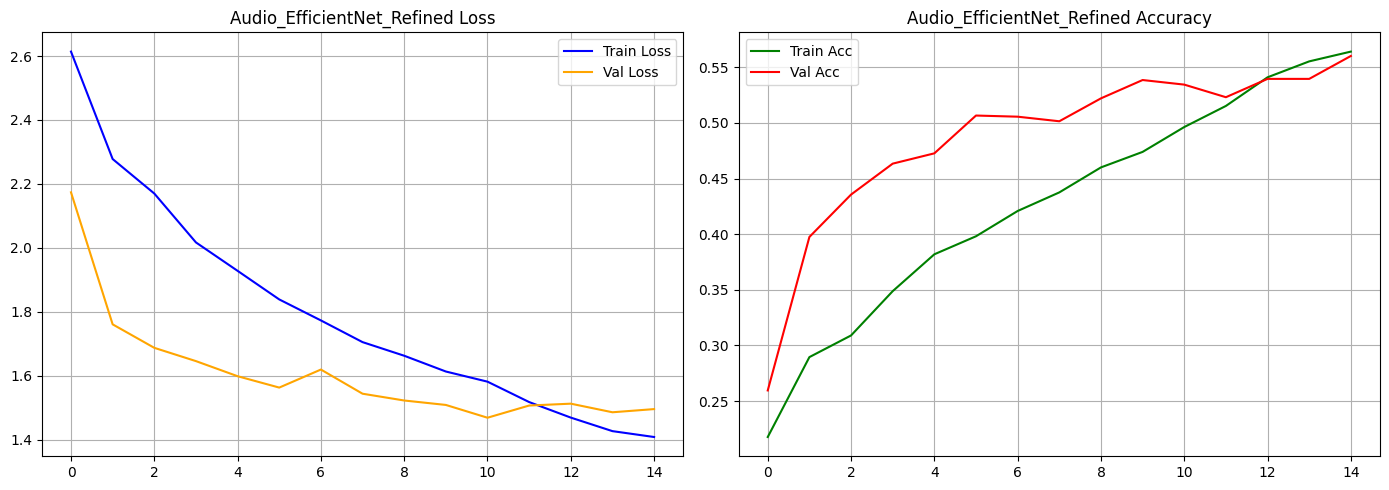

c:\Users\User\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


64/64 ━━━━━━━━━━━━━━━━━━━━ 24s 353ms/step


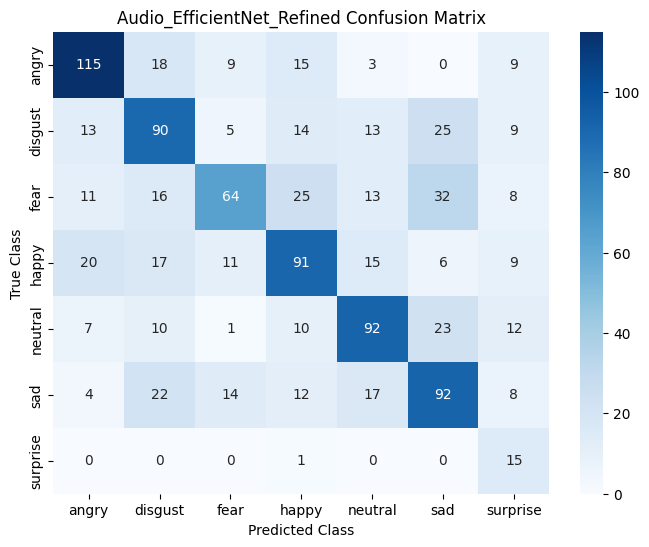

              precision    recall  f1-score   support

       angry       0.68      0.68      0.68       169
     disgust       0.52      0.53      0.53       169
        fear       0.62      0.38      0.47       169
       happy       0.54      0.54      0.54       169
     neutral       0.60      0.59      0.60       155
         sad       0.52      0.54      0.53       169
    surprise       0.21      0.94      0.35        16

    accuracy                           0.55      1016
   macro avg       0.53      0.60      0.53      1016
weighted avg       0.57      0.55      0.55      1016



In [10]:
visualize_training(hist, model, test_gen, NAME)

Fine Tune for BEST model

FACE

STARTING FINE-TUNING FOR: models_zoo_1/best_face.keras
Loaded Face_EfficientNetB0 with shape (224, 224)
Found 7962 validated image filenames belonging to 7 classes.
Found 971 validated image filenames belonging to 7 classes.
Found 1016 validated image filenames belonging to 7 classes.
Configuring layers for fine-tuning...
 -> No nested backbone found (Flat model).
 -> Frozen bottom layers of main model, Top 50 trainable.
Starting Aggressive Fine-Tuning...
Epoch 1/20
498/498 ━━━━━━━━━━━━━━━━━━━━ 215s 414ms/step - accuracy: 0.6634 - loss: 0.8128 - val_accuracy: 0.5479 - val_loss: 1.3393 - learning_rate: 1.0000e-05
Epoch 2/20
498/498 ━━━━━━━━━━━━━━━━━━━━ 205s 412ms/step - accuracy: 0.6687 - loss: 0.7991 - val_accuracy: 0.5489 - val_loss: 1.3392 - learning_rate: 1.0000e-05
Epoch 3/20
498/498 ━━━━━━━━━━━━━━━━━━━━ 206s 413ms/step - accuracy: 0.6746 - loss: 0.7817 - val_accuracy: 0.5499 - val_loss: 1.3806 - learning_rate: 1.0000e-05
Epoch 4/20
498/498 ━━━━━━━━━━━━━━━━━━━━ 209s 420ms/step - ac

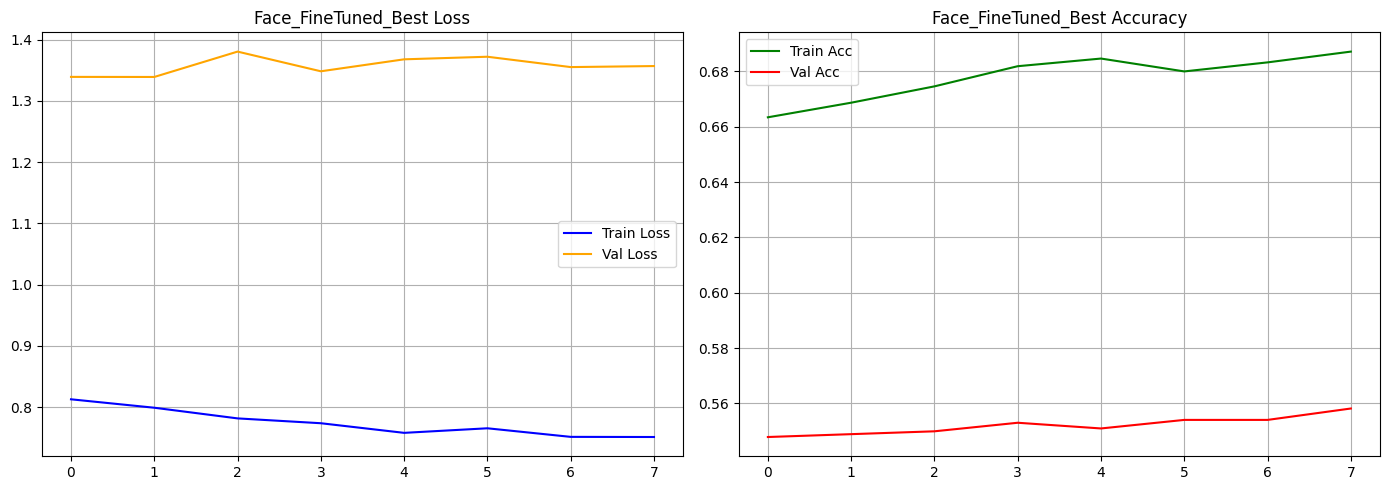

64/64 ━━━━━━━━━━━━━━━━━━━━ 18s 265ms/step


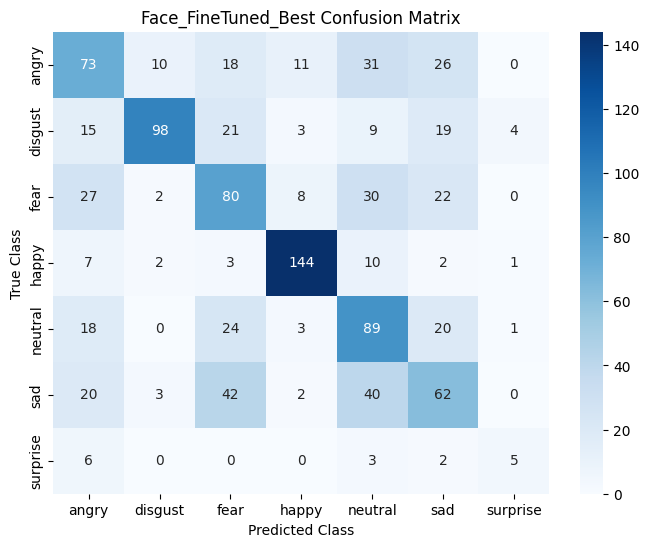

              precision    recall  f1-score   support

       angry       0.44      0.43      0.44       169
     disgust       0.85      0.58      0.69       169
        fear       0.43      0.47      0.45       169
       happy       0.84      0.85      0.85       169
     neutral       0.42      0.57      0.49       155
         sad       0.41      0.37      0.39       169
    surprise       0.45      0.31      0.37        16

    accuracy                           0.54      1016
   macro avg       0.55      0.51      0.52      1016
weighted avg       0.56      0.54      0.55      1016



In [ ]:
tf.keras.backend.clear_session()
import gc; gc.collect()
from tensorflow.keras.models import load_model

MODEL_PATH = "models_zoo_1/best_face.keras"
print(f"STARTING FINE-TUNING FOR: {MODEL_PATH}")

if not os.path.exists(MODEL_PATH):
    raise FileNotFoundError("CRITICAL: 'best_face.keras' not found.")

label_column = 'label'
if 'label_str' in train_df.columns:
    label_column = 'label_str'

model = load_model(MODEL_PATH)
model_config = model.get_config()
model_name_internal = model_config["name"] 
input_shape = model.input_shape[1:]
T_SIZE = (input_shape[0], input_shape[1])

print(f"Loaded {model_name_internal} with shape {T_SIZE}")

if "Xception" in model_name_internal:
    from tensorflow.keras.applications.xception import preprocess_input as my_preprocess
elif "ResNet" in model_name_internal:
    from tensorflow.keras.applications.resnet50 import preprocess_input as my_preprocess
else:
    from tensorflow.keras.applications.efficientnet import preprocess_input as my_preprocess

train_datagen = ImageDataGenerator(
    preprocessing_function=my_preprocess,
    rotation_range=15,      
    width_shift_range=0.2, 
    height_shift_range=0.2,
    zoom_range=0.2, 
    brightness_range=[0.7, 1.3], # <--- NEW: Helps with lighting
    horizontal_flip=True, 
    fill_mode='nearest'
)
test_datagen = ImageDataGenerator(preprocessing_function=my_preprocess)

train_g = train_datagen.flow_from_dataframe(train_df, x_col='face_path', y_col=label_column, target_size=T_SIZE, batch_size=16, class_mode='categorical')
val_g = test_datagen.flow_from_dataframe(val_df, x_col='face_path', y_col=label_column, target_size=T_SIZE, batch_size=16, class_mode='categorical', shuffle=False)
test_g = test_datagen.flow_from_dataframe(test_df, x_col='face_path', y_col=label_column, target_size=T_SIZE, batch_size=16, class_mode='categorical', shuffle=False)

print("Configuring layers for fine-tuning...")

backbone = None
for layer in model.layers:
    if hasattr(layer, 'layers') and len(layer.layers) > 0:
        backbone = layer
        break

if backbone:
    print(f" -> Found nested backbone: {backbone.name}")
    backbone.trainable = True
    # Freeze bottom layers of the BACKBONE, leave top 50 open
    for layer in backbone.layers[:-50]:
        layer.trainable = False
    print(f" -> Frozen bottom layers of {backbone.name}, Top 50 trainable.")
else:
    print(" -> No nested backbone found (Flat model).")
    # Fallback for flat models (ResNet/Xception might be flat)
    for layer in model.layers: layer.trainable = False
    for layer in model.layers[-50:]: layer.trainable = True
    print(" -> Frozen bottom layers of main model, Top 50 trainable.")

model.compile(optimizer=Adam(1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

callbacks = [
    EarlyStopping(patience=6, restore_best_weights=True),
    ModelCheckpoint("models_zoo_1/best_face_finetuned.keras", save_best_only=True, monitor='val_accuracy'),
    ReduceLROnPlateau(factor=0.2, patience=3, verbose=1, min_lr=1e-7)
]

print("Starting Aggressive Fine-Tuning...")
start_train = time.time()

hist = model.fit(
    train_g, 
    validation_data=val_g, 
    epochs=20, 
    callbacks=callbacks, 
    class_weight=class_weights_dict,
    verbose=1
)

end_train = time.time()
print(f"Total Training Time: {(end_train - start_train) / 60:.2f} minutes")

model.load_weights("models_zoo_1/best_face_finetuned.keras")
visualize_training(hist, model, test_g, "Face_FineTuned_Best")

AUDIO

STARTING AUDIO FINE-TUNING FOR: models_zoo_1/best_audio.keras
 -> Model loaded: Audio_EfficientNet. Shape: (224, 224)
Configuring layers for fine-tuning...
 -> No nested backbone found (Flat model).
 -> Frozen bottom layers of main model, Top 30 trainable.
Starting Audio Fine-Tuning...
Epoch 1/20
498/498 ━━━━━━━━━━━━━━━━━━━━ 178s 343ms/step - accuracy: 0.6736 - loss: 0.8237 - val_accuracy: 0.5427 - val_loss: 1.3456 - learning_rate: 1.0000e-05
Epoch 2/20
498/498 ━━━━━━━━━━━━━━━━━━━━ 169s 339ms/step - accuracy: 0.6854 - loss: 0.7997 - val_accuracy: 0.5427 - val_loss: 1.3515 - learning_rate: 1.0000e-05
Epoch 3/20
498/498 ━━━━━━━━━━━━━━━━━━━━ 169s 339ms/step - accuracy: 0.7023 - loss: 0.7748 - val_accuracy: 0.5376 - val_loss: 1.3500 - learning_rate: 1.0000e-05
Epoch 4/20
498/498 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step - accuracy: 0.6925 - loss: 0.7790
Epoch 4: ReduceLROnPlateau reducing learning rate to 1.9999999494757505e-06.
498/498 ━━━━━━━━━━━━━━━━━━━━ 170s 342ms/step - accuracy: 0.6951 - lo

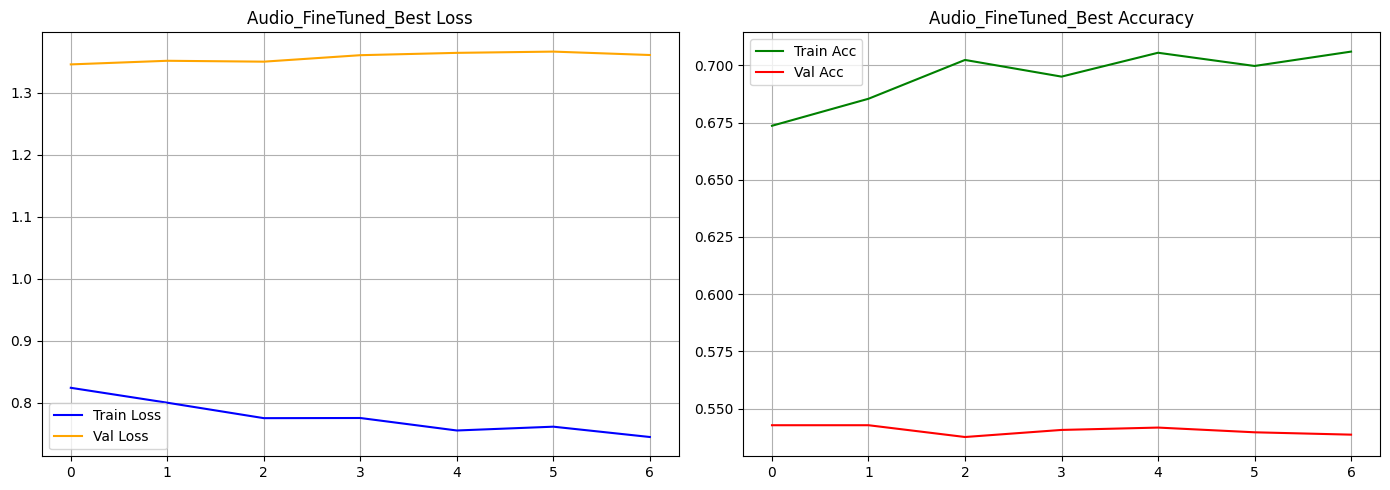

64/64 ━━━━━━━━━━━━━━━━━━━━ 18s 266ms/step


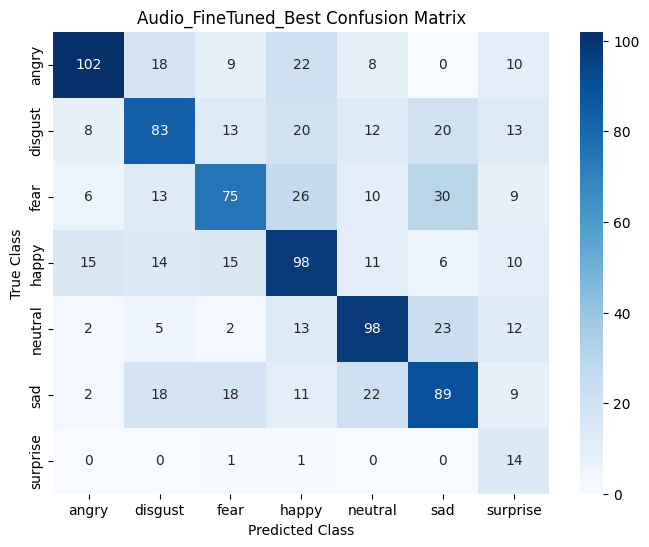

              precision    recall  f1-score   support

       angry       0.76      0.60      0.67       169
     disgust       0.55      0.49      0.52       169
        fear       0.56      0.44      0.50       169
       happy       0.51      0.58      0.54       169
     neutral       0.61      0.63      0.62       155
         sad       0.53      0.53      0.53       169
    surprise       0.18      0.88      0.30        16

    accuracy                           0.55      1016
   macro avg       0.53      0.59      0.53      1016
weighted avg       0.58      0.55      0.56      1016



In [ ]:
tf.keras.backend.clear_session()
import gc; gc.collect()
import time
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

MODEL_PATH = "models_zoo_1/best_audio.keras"
print(f"STARTING AUDIO FINE-TUNING FOR: {MODEL_PATH}")

if not os.path.exists(MODEL_PATH):
    raise FileNotFoundError("CRITICAL: 'best_audio.keras' not found. Run Cell 21 first!")

model = load_model(MODEL_PATH)
model_config = model.get_config()
input_shape = model.input_shape[1:]
T_SIZE = (input_shape[0], input_shape[1])
model_name_internal = model_config["name"]

print(f" -> Model loaded: {model_name_internal}. Shape: {T_SIZE}")

if "ResNet" in model_name_internal:
    from tensorflow.keras.applications.resnet50 import preprocess_input as base_pre
    def audio_preprocess_wrapper(img): return base_pre(img * 255.0)
elif "Xception" in model_name_internal:
    from tensorflow.keras.applications.xception import preprocess_input as base_pre
    def audio_preprocess_wrapper(img): return base_pre(img * 255.0)
else:
    # Default to EfficientNet
    from tensorflow.keras.applications.efficientnet import preprocess_input as base_pre
    def audio_preprocess_wrapper(img): return base_pre(img * 255.0)

train_gen = NpyDataGenerator(train_aud, audio_preprocess_wrapper, batch_size=16, target_size=T_SIZE)
val_gen = NpyDataGenerator(val_aud, audio_preprocess_wrapper, batch_size=16, target_size=T_SIZE, shuffle=False)
test_gen = NpyDataGenerator(test_aud, audio_preprocess_wrapper, batch_size=16, target_size=T_SIZE, shuffle=False)

print("Configuring layers for fine-tuning...")

backbone = None
for layer in model.layers:
    if hasattr(layer, 'layers') and len(layer.layers) > 0:
        backbone = layer
        break

if backbone:
    print(f" -> Found nested backbone: {backbone.name}")
    backbone.trainable = True
    # Freeze bottom layers of the BACKBONE, leave top 30 open
    # Audio features are simpler, so we unfreeze fewer layers than Face
    for layer in backbone.layers[:-30]:
        layer.trainable = False
    print(f" -> Frozen bottom layers of {backbone.name}, Top 30 trainable.")
else:
    print(" -> No nested backbone found (Flat model).")
    for layer in model.layers: layer.trainable = False
    for layer in model.layers[-30:]: layer.trainable = True
    print(" -> Frozen bottom layers of main model, Top 30 trainable.")

model.compile(optimizer=Adam(1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

callbacks = [
    EarlyStopping(patience=6, restore_best_weights=True),
    ModelCheckpoint("models_zoo_1/best_audio_finetuned.keras", save_best_only=True, monitor='val_accuracy'),
    ReduceLROnPlateau(factor=0.2, patience=3, verbose=1, min_lr=1e-7)
]

print("Starting Audio Fine-Tuning...")
start_train = time.time()

hist = model.fit(
    train_gen, 
    validation_data=val_gen, 
    epochs=20, 
    callbacks=callbacks, 
    class_weight=class_weights_dict, 
    verbose=1
)

end_train = time.time()
print(f"Total Audio Fine-Tuning Time: {(end_train - start_train) / 60:.2f} minutes")

model.load_weights("models_zoo_1/best_audio_finetuned.keras")
visualize_training(hist, model, test_gen, "Audio_FineTuned_Best")

### Model Comparison After Fine Tuning

In [ ]:
# --- CONFIGURATION ---
BATCH_SIZE = 16
MODEL_DIR = "models_zoo_1"  

# Define the candidates
candidates = {
    "Face Base": f"{MODEL_DIR}/best_face.keras",
    "Face FineTuned": f"{MODEL_DIR}/best_face_finetuned.keras",
    "Audio Base": f"{MODEL_DIR}/best_audio.keras",
    "Audio FineTuned": f"{MODEL_DIR}/best_audio_finetuned.keras"
}

# --- GENERATORS (With RGB Fix) ---
class FaceTestGen(Sequence):
    def __init__(self, df, batch_size=16):
        self.df = df
        self.batch_size = batch_size
        self.indices = np.arange(len(df))
    
    def __len__(self): return int(np.ceil(len(self.df) / self.batch_size))
    
    def __getitem__(self, idx):
        inds = self.indices[idx*self.batch_size:(idx+1)*self.batch_size]
        batch_X, batch_y = [], []
        for i in inds:
            row = self.df.iloc[i]
            # Face
            img = cv2.imread(row['face_path'])
            if img is None: img = np.zeros((224,224,3))
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # <--- CRITICAL FIX
            img = cv2.resize(img, (224, 224))
            img = tf.keras.applications.efficientnet.preprocess_input(img.astype(float))
            batch_X.append(img)
            batch_y.append(row['label_encoded'])
        return np.array(batch_X), tf.keras.utils.to_categorical(batch_y, num_classes=7)

class AudioTestGen(Sequence):
    def __init__(self, df, batch_size=16):
        self.df = df
        self.batch_size = batch_size
        self.indices = np.arange(len(df))
    
    def __len__(self): return int(np.ceil(len(self.df) / self.batch_size))
    
    def __getitem__(self, idx):
        inds = self.indices[idx*self.batch_size:(idx+1)*self.batch_size]
        batch_X, batch_y = [], []
        for i in inds:
            row = self.df.iloc[i]
            # Audio
            spec = np.load(row['audio_path'])
            spec = cv2.resize(spec, (224, 224))
            if len(spec.shape)==2: spec = np.stack((spec,)*3, axis=-1)
            if np.max(spec) <= 1.0: spec = spec * 255.0
            spec = tf.keras.applications.efficientnet.preprocess_input(spec.astype(float))
            batch_X.append(spec)
            batch_y.append(row['label_encoded'])
        return np.array(batch_X), tf.keras.utils.to_categorical(batch_y, num_classes=7)

# --- RUN EVALUATION ---
print(f"{'MODEL NAME':<25} | {'STATUS':<15} | {'ACCURACY':<10}")
print("-" * 55)

results = {}

for name, path in candidates.items():
    if not os.path.exists(path):
        print(f"{name:<25} | {'NOT FOUND':<15} | {'N/A':<10}")
        continue
        
    # Select correct generator
    if "Face" in name:
        gen = FaceTestGen(test_df, BATCH_SIZE) # Assumes test_df exists
    else:
        gen = AudioTestGen(test_aud, BATCH_SIZE) # Assumes test_aud exists
        
    try:
        # Load without compiling to avoid custom object errors
        model = load_model(path, compile=False)
        model.compile(loss='categorical_crossentropy', metrics=['accuracy'])
        
        loss, acc = model.evaluate(gen, verbose=0)
        results[name] = acc
        print(f"{name:<25} | {'Evaluated':<15} | {acc*100:.2f}%")
        
        # Free memory
        del model
        tf.keras.backend.clear_session()
        
    except Exception as e:
        print(f"{name:<25} | {'ERROR':<15} | {str(e)[:10]}")

print("-" * 55)
print("Recommendation:")
best_face = max({k:v for k,v in results.items() if "Face" in k}, key=results.get, default="None")
best_audio = max({k:v for k,v in results.items() if "Audio" in k}, key=results.get, default="None")
print(f"Use Face Model:  {candidates.get(best_face, 'None')}")
print(f"Use Audio Model: {candidates.get(best_audio, 'None')}")

MODEL NAME                | STATUS          | ACCURACY  
-------------------------------------------------------


c:\Users\User\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Face Base                 | Evaluated       | 54.82%
Face FineTuned            | Evaluated       | 54.23%
Audio Base                | Evaluated       | 52.36%
Audio FineTuned           | Evaluated       | 55.02%
-------------------------------------------------------
Recommendation:
Use Face Model:  models_zoo_1/best_face.keras
Use Audio Model: models_zoo_1/best_audio_finetuned.keras


## Model Fusion

--- Loading Datasets ---
Data Loaded Successfully.
--- Encoding Labels ---
Classes: ['angry' 'disgust' 'fear' 'happy' 'neutral' 'sad' 'surprise']
--- Calculating Class Weights ---
Class Weights Calculated: {0: np.float64(0.8893108455266391), 1: np.float64(0.8893108455266391), 2: np.float64(0.8886160714285715), 3: np.float64(0.8907036581273073), 4: np.float64(0.8886160714285715), 5: np.float64(0.8893108455266391), 6: np.float64(3.949404761904762)}
--- Building Model with Refined Regularization ---


Starting Training with Class Weights...
Epoch 1/30
498/498 ━━━━━━━━━━━━━━━━━━━━ 375s 731ms/step - accuracy: 0.5278 - loss: 3.6052 - val_accuracy: 0.6612 - val_loss: 3.0955 - learning_rate: 1.0000e-04
Epoch 2/30
498/498 ━━━━━━━━━━━━━━━━━━━━ 387s 777ms/step - accuracy: 0.6835 - loss: 2.9941 - val_accuracy: 0.7106 - val_loss: 2.9209 - learning_rate: 1.0000e-04
Epoch 3/30
498/498 ━━━━━━━━━━━━━━━━━━━━ 378s 758ms/step - accuracy: 0.7317 - loss: 2.7290 - val_accuracy: 0.7178 - val_loss: 2.7682 - le

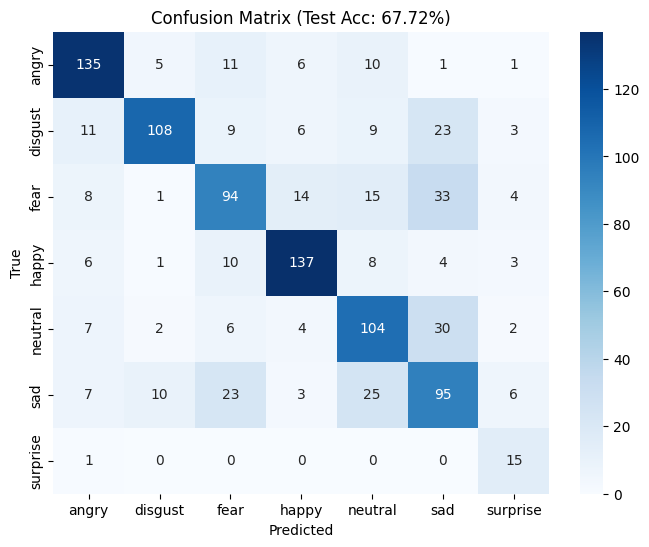

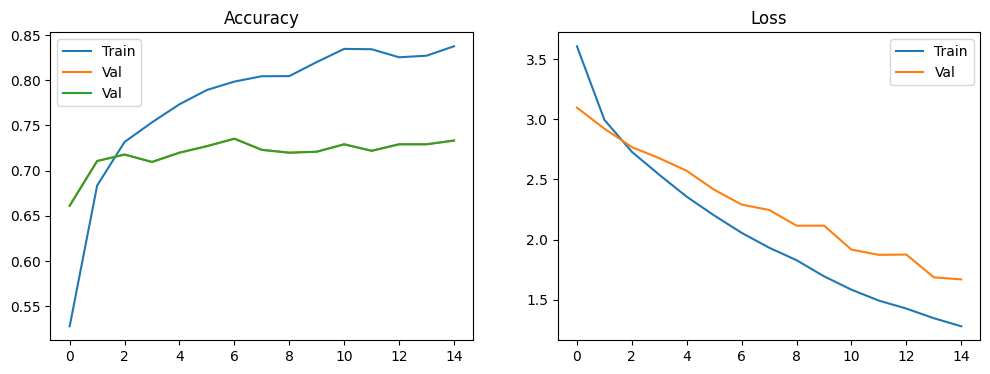

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, Concatenate, Multiply, Lambda, BatchNormalization
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import Sequence, to_categorical
from tensorflow.keras.regularizers import l2 
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import class_weight
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import cv2
import os

FACE_PATH = "models_zoo_1/efficientnet_improved.keras" 
AUDIO_PATH = "models_zoo_1/Audio_EfficientNet_Refined.keras"
SAVE_NAME = "models_zoo_1/modelfusion_2.keras"
DATA_DIR = r"C:\Users\User\Multimodel AI\data_1" 

BATCH_SIZE = 16
EPOCHS = 30 # Increased for more training time

print("--- Loading Datasets ---")
try:
    train_df = pd.read_csv(os.path.join(DATA_DIR, "train_face.csv"))
    val_df = pd.read_csv(os.path.join(DATA_DIR, "val_face.csv"))
    test_df = pd.read_csv(os.path.join(DATA_DIR, "test_face.csv"))
    
    train_aud = pd.read_csv(os.path.join(DATA_DIR, "train_audio.csv"))
    val_aud = pd.read_csv(os.path.join(DATA_DIR, "val_audio.csv"))
    test_aud = pd.read_csv(os.path.join(DATA_DIR, "test_audio.csv"))
    
    # Clean Columns
    for df in [train_df, val_df, test_df]:
        df.columns = df.columns.str.strip()
        if 'label_str' not in df.columns and 'label' in df.columns:
            df['label_str'] = df['label'].astype(str)
            
    print("Data Loaded Successfully.")

except FileNotFoundError:
    print(f"CRITICAL ERROR: Could not find CSV files in {DATA_DIR}")
    raise

print("--- Encoding Labels ---")
le = LabelEncoder()
all_labels = pd.concat([train_df['label_str'], val_df['label_str'], test_df['label_str']])
le.fit(all_labels)

# Apply encoding to all sets
train_df['label_encoded'] = le.transform(train_df['label_str'])
val_df['label_encoded'] = le.transform(val_df['label_str'])
test_df['label_encoded'] = le.transform(test_df['label_str'])
print(f"Classes: {le.classes_}")

class FusionGenerator(Sequence):
    def __init__(self, face_df, audio_df, batch_size=16, shuffle=True, face_augment=False):
        super().__init__()
        # Merge on original_id to sync face/audio
        self.merged = pd.merge(face_df, audio_df[['original_id', 'audio_path']], on='original_id')
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.face_augment = face_augment # NEW FLAG for augmentation
        self.indices = np.arange(len(self.merged))
        
        if 'audio_path_y' in self.merged.columns:
            self.audio_col = 'audio_path_y'
        else:
            self.audio_col = 'audio_path'

        self.labels = self.merged['label_encoded'].values
        self.on_epoch_end()
        
    def _random_flip(self, image):
        if np.random.rand() < 0.5:
            image = cv2.flip(image, 1) 
        return image

    def _random_crop_and_resize(self, image, size=224):
        s = image.shape
        if self.face_augment and np.random.rand() < 0.3:
            # Randomly pick a crop size between 80% and 100%
            crop_factor = np.random.uniform(0.8, 1.0) 
            new_h, new_w = int(s[0] * crop_factor), int(s[1] * crop_factor)
            
            start_y = np.random.randint(0, s[0] - new_h + 1)
            start_x = np.random.randint(0, s[1] - new_w + 1)
            
            image = image[start_y:start_y + new_h, start_x:start_x + new_w]
        
        return cv2.resize(image, (size, size)) 

    def _random_brightness(self, image):
        if self.face_augment and np.random.rand() < 0.3:
            hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            # Randomly adjust V channel by 80% to 120%
            h, s, v = cv2.split(hsv)
            v = np.clip(v * np.random.uniform(0.8, 1.2), 0, 255).astype(v.dtype)
            hsv = cv2.merge([h, s, v])
            image = cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)
        return image

    def __len__(self): return int(np.ceil(len(self.merged) / self.batch_size))
    
    def on_epoch_end(self): 
        if self.shuffle: np.random.shuffle(self.indices)

    def __getitem__(self, idx):
        idxs = self.indices[idx*self.batch_size:(idx+1)*self.batch_size]
        rows = self.merged.iloc[idxs]
        
        X_f, X_a, y = [], [], []
        for i, (_, row) in enumerate(rows.iterrows()):
            # Face (Load BGR -> Convert RGB)
            img = cv2.imread(row['face_path'])
            if img is None: img = np.zeros((224,224,3))
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # RGB Fix
            
            # === APPLY AUGMENTATION FOR TRAINING ONLY ===
            if self.face_augment:
                img = self._random_flip(img)
                img = self._random_brightness(img)
            
            # Cropping/Resizing is applied here (conditionally cropped if face_augment is True)
            img = self._random_crop_and_resize(img, size=224) 

            # Preprocess
            img = tf.keras.applications.efficientnet.preprocess_input(img.astype(float))
            X_f.append(img)
            
            # Audio
            spec = np.load(row[self.audio_col])
            spec = cv2.resize(spec, (224, 224))
            if len(spec.shape)==2: spec = np.stack((spec,)*3, axis=-1)
            if np.max(spec) <= 1.0: spec = spec * 255.0
            spec = tf.keras.applications.efficientnet.preprocess_input(spec.astype(float))
            X_a.append(spec)
            
            y.append(self.labels[idxs[i]])
        
        inputs = { "face_input_new": np.array(X_f), "audio_input_new": np.array(X_a) }
        return inputs, to_categorical(y, num_classes=7)

def build_model():
    print("--- Building Model with Refined Regularization ---")
    # safe_mode=False is usually only needed for loading custom layers, but use it to be robust
    face_base = load_model(FACE_PATH, compile=False, safe_mode=False) 
    audio_base = load_model(AUDIO_PATH, compile=False, safe_mode=False)
    
    # Create Feature Extractors (Frozen)
    face_extractor = Model(inputs=face_base.input, outputs=face_base.layers[-3].output, name="face_extractor")
    audio_extractor = Model(inputs=audio_base.input, outputs=audio_base.layers[-3].output, name="audio_extractor")
    
    face_extractor.trainable = False
    audio_extractor.trainable = False
    
    # Inputs
    input_f = Input(shape=(224, 224, 3), name="face_input_new")
    input_a = Input(shape=(224, 224, 3), name="audio_input_new")
    
    # Features
    f_feat = face_extractor(input_f)
    a_feat = audio_extractor(input_a)
    
    # Gated Fusion
    concat = Concatenate(name="fusion_concat")([f_feat, a_feat])
    z = Dense(1, activation="sigmoid", name="fusion_gate")(concat) 
    
    f_w = Multiply(name="face_weighted")([f_feat, z])
    inverse_gate = Lambda(lambda x: 1.0 - x, name="inverse_gate")(z)
    a_w = Multiply(name="audio_weighted")([a_feat, inverse_gate])
    
    merged = Concatenate(name="weighted_concat")([f_w, a_w])
    
    # --- CLASSIFIER WITH MODIFIED REGULARIZATION ---
    # L2 Regularization slightly reduced to 0.005
    x = Dense(256, activation='relu', kernel_regularizer=l2(0.005), name="fusion_dense")(merged)
    x = BatchNormalization(name="fusion_bn")(x)
    # Dropout slightly reduced to 0.5
    x = Dropout(0.5, name="fusion_dropout")(x)
    out = Dense(7, activation='softmax', name="fusion_output")(x)
    
    model = Model(inputs=[input_f, input_a], outputs=out, name="Gated_Fusion_Model")
    return model

print("--- Calculating Class Weights ---")
# Build & Compile
# Initialize TRAIN generator WITH augmentation
gen_train = FusionGenerator(train_df, train_aud, batch_size=BATCH_SIZE, face_augment=True)
# Initialize VAL generator WITHOUT augmentation
gen_val = FusionGenerator(val_df, val_aud, batch_size=BATCH_SIZE, face_augment=False)

# Calculate Weights
y_train = gen_train.labels 
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights_dict = dict(enumerate(class_weights))
print(f"Class Weights Calculated: {class_weights_dict}")

model = build_model()
model.compile(optimizer=Adam(1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

print("\nStarting Training with Class Weights...")
history = model.fit(
    gen_train,
    validation_data=gen_val,
    epochs=EPOCHS,
    class_weight=class_weights_dict, 
    callbacks=[
        EarlyStopping(monitor='val_accuracy', patience=8, restore_best_weights=True), # Increased patience
        ModelCheckpoint(SAVE_NAME, save_best_only=True, monitor='val_accuracy'),
        ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-7, verbose=1)
    ]
)

print("\n--- Final Evaluation on Test Set ---")
gen_test = FusionGenerator(test_df, test_aud, batch_size=BATCH_SIZE, shuffle=False, face_augment=False)

# Predict
y_pred_probs = model.predict(gen_test, verbose=1)
y_pred = np.argmax(y_pred_probs, axis=1)

# Get True Labels safely
y_true = gen_test.merged['label_encoded'].values[:len(y_pred)]

# Metrics
acc = accuracy_score(y_true, y_pred)
print(f"\nFINAL TEST ACCURACY: {acc:.4f}")
print("-" * 30)
print(classification_report(y_true, y_pred, target_names=le.classes_))

# Plot Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title(f'Confusion Matrix (Test Acc: {acc:.2%})')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Plot History
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Val')
plt.title('Accuracy')
plt.plot(history.history['val_accuracy'], label='Val')
plt.title('Accuracy')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Val')
plt.title('Loss')
plt.legend()
plt.show()

In [ ]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import cv2
import joblib
from tensorflow.keras.models import load_model
from tensorflow.keras.applications.efficientnet import preprocess_input as eff_preprocess
from tensorflow.keras.applications.resnet50 import preprocess_input as res_preprocess
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

# --- NEW SKLEARN MODELS ---
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.svm import SVC

# --- 1. CONFIGURATION ---
DATA_DIR = r"C:\Users\User\Multimodel AI\data_1" 
MODEL_DIR = "models_zoo_1"

# YOUR SPECIFIC PATHS
PATH_FUSION = os.path.join(MODEL_DIR, "Model_Fusion.keras")
PATH_FACE   = os.path.join(MODEL_DIR, "best_face.keras")
PATH_AUDIO  = os.path.join(MODEL_DIR, "best_audio_finetuned.keras")

print("--- Loading Metadata ---")
df_face = pd.read_csv(os.path.join(DATA_DIR, "test_face.csv"))
df_audio = pd.read_csv(os.path.join(DATA_DIR, "test_audio.csv"))

# Encode Labels
le = LabelEncoder()
all_labels = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
le.fit(all_labels)

df_face['label_encoded'] = le.transform(df_face['label'].astype(str))
df_audio['label_encoded'] = le.transform(df_audio['label'].astype(str))

# --- 2. PREPROCESSING HELPERS ---
def eff_audio_wrapper(img):
    if np.max(img) <= 1.0: img = img * 255.0
    return eff_preprocess(img)

def resnet_audio_wrapper(img):
    if np.max(img) <= 1.0: img = img * 255.0
    return res_preprocess(img)

def get_preprocess_func(model):
    # Try to detect if ResNet is used based on layer names or model name
    try:
        model_config = model.get_config()
        model_name = model_config.get('name', '').lower()
        if "resnet" in model_name:
            return resnet_audio_wrapper
    except:
        pass
    return eff_preprocess

# --- 3. FEATURE EXTRACTION FUNCTION ---
def extract_all_features(model_face, model_audio, model_fusion, df_face, df_audio, target_size=(224,224)):
    print("Extracting features from ALL 3 models (Face, Audio, Fusion)...")
    
    # Preprocessing functions
    pre_face = get_preprocess_func(model_face)
    pre_audio = get_preprocess_func(model_audio)
    
    preds_face = []
    preds_audio = []
    preds_fusion = []
    
    # Iterate row by row to ensure alignment
    total = len(df_face)
    for idx in range(total):
        # 1. Load Face
        f_path = df_face.iloc[idx]['face_path']
        img_f = cv2.imread(f_path)
        img_f = cv2.cvtColor(img_f, cv2.COLOR_BGR2RGB)
        if img_f.shape[:2] != target_size:
            img_f = cv2.resize(img_f, target_size)
        X_f = pre_face(img_f.astype(np.float32))
        X_f = np.expand_dims(X_f, axis=0)

        # 2. Load Audio
        a_path = df_audio.iloc[idx]['audio_path']
        spec = np.load(a_path)
        if spec.shape[:2] != target_size:
            spec = cv2.resize(spec, target_size)
        if len(spec.shape) == 2:
            spec = np.stack((spec,)*3, axis=-1)
        X_a = pre_audio(spec.astype(np.float32))
        X_a = np.expand_dims(X_a, axis=0)
        
        # 3. Predict Single Models
        p_f = model_face.predict(X_f, verbose=0)[0]
        p_a = model_audio.predict(X_a, verbose=0)[0]
        
        # 4. Predict Fusion (Multi-Input)
        p_fus = model_fusion.predict([X_f, X_a], verbose=0)[0]
        
        preds_face.append(p_f)
        preds_audio.append(p_a)
        preds_fusion.append(p_fus)
        
        if idx % 50 == 0:
            print(f"   Processed {idx}/{total}", end="\r")

    return np.array(preds_face), np.array(preds_audio), np.array(preds_fusion)

# --- 4. LOAD MODELS (FIXED) ---
print("\n--- Loading Models ---")
if not os.path.exists(PATH_FUSION): print(f"MISSING: {PATH_FUSION}"); exit()
if not os.path.exists(PATH_FACE): print(f"MISSING: {PATH_FACE}"); exit()
if not os.path.exists(PATH_AUDIO): print(f"MISSING: {PATH_AUDIO}"); exit()

# FIX: Added safe_mode=False to allow Lambda layers
model_fus = load_model(PATH_FUSION, compile=False, safe_mode=False)
model_face = load_model(PATH_FACE, compile=False, safe_mode=False)
model_aud = load_model(PATH_AUDIO, compile=False, safe_mode=False)

# --- 5. GENERATE META-FEATURES ---
p_face, p_audio, p_fusion = extract_all_features(model_face, model_aud, model_fus, df_face, df_audio)

# Stack them: [Face(7) | Audio(7) | Fusion(7)] -> 21 Features
X_meta = np.hstack([p_face, p_audio, p_fusion])
y_meta = df_face['label_encoded'].values

# Split for Meta-Training
X_train, X_test, y_train, y_test = train_test_split(X_meta, y_meta, test_size=0.2, random_state=42, stratify=y_meta)

print(f"\nMeta-Feature Shape: {X_meta.shape} (Should be N x 21)")

# --- 6. TRAIN CANDIDATES ---
candidates = {
    "LogisticRegression": LogisticRegression(max_iter=1000, C=0.5),
    "XGBoost": XGBClassifier(n_estimators=100, learning_rate=0.05, eval_metric='mlogloss', use_label_encoder=False),
    "RandomForest": RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42),
    "SVM": SVC(kernel='rbf', probability=True, C=1.0),
    "ExtraTrees": ExtraTreesClassifier(n_estimators=100, random_state=42)
}

results = {}
trained_models = {}

print("\n--- Training Meta-Learner Candidates ---")
for name, clf in candidates.items():
    print(f"Training {name}...", end="")
    clf.fit(X_train, y_train)
    acc = clf.score(X_test, y_test)
    results[name] = acc
    trained_models[name] = clf
    print(f" Accuracy: {acc*100:.2f}%")

# --- 7. SELECT TOP 2 & MIX ---
sorted_results = sorted(results.items(), key=lambda x: x[1], reverse=True)
top_1_name, top_1_score = sorted_results[0]
top_2_name, top_2_score = sorted_results[1]

print(f"\nTop 1: {top_1_name} ({top_1_score*100:.2f}%)")
print(f"Top 2: {top_2_name} ({top_2_score*100:.2f}%)")

print("\n--- Creating 'Mix 2' (Voting Ensemble) ---")
estimators = [
    (top_1_name, trained_models[top_1_name]),
    (top_2_name, trained_models[top_2_name])
]
voting_clf = VotingClassifier(estimators=estimators, voting='soft')
voting_clf.fit(X_train, y_train)

mix_acc = voting_clf.score(X_test, y_test)
print(f"Mix 2 ({top_1_name} + {top_2_name}) Accuracy: {mix_acc*100:.2f}%")

# --- 8. SAVE THE WINNER ---
if mix_acc > top_1_score:
    final_winner = voting_clf
    winner_name = "Mix_2_Voting"
else:
    final_winner = trained_models[top_1_name]
    winner_name = top_1_name

print(f"\nWINNER: {winner_name}")
save_path = os.path.join(MODEL_DIR, "best_meta_learner_v2.pkl")
joblib.dump(final_winner, save_path)
print(f"Saved best meta-learner to {save_path}")

--- Loading Metadata ---

--- Loading Models ---

Extracting features from ALL 3 models (Face, Audio, Fusion)...
   Processed 1000/1016
Meta-Feature Shape: (1016, 21) (Should be N x 21)

--- Training Meta-Learner Candidates ---
Training LogisticRegression... Accuracy: 52.45%
Training XGBoost...

c:\Users\User\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:199: UserWarning: [12:39:53] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


 Accuracy: 73.04%
Training RandomForest... Accuracy: 72.06%
Training SVM... Accuracy: 56.37%
Training ExtraTrees... Accuracy: 70.59%

Top 1: XGBoost (73.04%)
Top 2: RandomForest (72.06%)

--- Creating 'Mix 2' (Voting Ensemble) ---


c:\Users\User\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:199: UserWarning: [12:39:55] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Mix 2 (XGBoost + RandomForest) Accuracy: 72.55%

WINNER: XGBoost
Saved best meta-learner to models_zoo_1\best_meta_learner_v2.pkl
